# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立与评价等

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
import os
from model_util import *
from CaBoost_function import *
from LightGBM_function import *
from XGBoost_function import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
# % config ZMQInteractiveShell.ast_node_interactivity='all'

# 1.数据获取

In [5]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [6]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [7]:
# 特征列表
feature_list = list(data)
print(feature_list)
df = data.copy()
df.head()

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [8]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
print(df_01.shape)

(42535, 144)
(42535, 126)


In [9]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [10]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [11]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [12]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [13]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [14]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [15]:
# 2.8 数据类型查看与转换
obj_feature = obj_feature(df_final)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']


In [16]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique()) 
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


In [17]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc
print(df_finals.shape)
df_finals.columns

(31534, 28)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'next_pymnt_d', 'pub_rec_bankruptcies', 'pnt_loan_annual'],
      dtype='object')

In [18]:
# 特征列表分类
# 离散(类别型)特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)

# 标签
df_label=['loan_status']

# 连续型特征
num_feature = df_finals.copy().columns.drop(time_feature).drop(char_feature).drop(df_label)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
print(len(num_feature))

19


In [19]:
# *数据探索
# 类别型(离散)特征: 每个特征值分布概率值
df_finals['emp_length'] = df_finals['emp_length'].astype('str')
# df_finals['emp_length'].dtypes
rate_feature_all = data_distributed(df_finals, char_feature)
# rate_feature_all

In [20]:
# 2.10 缺失值查看与处理
# 离散特征
print(df_finals[char_feature].isnull().sum())
print('==============next=============')

# 连续型特征
print(df_finals[num_feature].isnull().sum())
# 缺失值处理：-999填充
df_s = df_finals.fillna(-999)

emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
dtype: int64
==============next=============
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
annual_inc                    4
dti                           0
delinq_2yrs                  30
inq_last_6mths               29
mths_since_last_delinq    19747
mths_since_last_record    28530
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   86
total_acc                    30
pub_rec_bankruptcies       1365
pnt_loan_annual               4
dtype: int64


In [21]:
# 重命名与定义y标签：贷款状态(好样本0，坏样本1)
df_s=df_s.rename(columns={'loan_status':'y'})
df_s['y'].value_counts()

0    27658
1     3876
Name: y, dtype: int64

# 3.特征工程

In [22]:
# 根据iv值、相关性、多重共线性等筛选特征

In [26]:
# 3.1 根据iv值筛选特征
# 1)离散(类别型)特征
char_df = pd.concat([df_s[char_feature], df_s['y']], axis=1)
feature_name_iv = cal_charf_iv(char_df, label='y')
feature_name_iv

# 2) 连续性特征
num_features = num_feature.copy().drop('term')
num_df = df_s[num_features]
num_df.shape
num_feature_name_iv = cal_numf_iv(df_s, num_df, label='y')
num_feature_name_iv

# 3)合并离散和连续的特征iv值
all_feature_iv = pd.concat([feature_name_iv, num_feature_name_iv],axis=0).reset_index().drop('index', axis=1)
all_feature_iv
 
# 4) 特征筛选_取iv值范围：[0.01, 0.5)
feature_sels_vi = get_result_iv(all_feature_iv, low_th=0.01, high_th=0.5)
sel_feature_ = list(feature_sels_vi.feature_name)  # 筛选后的特征列表：sel_feature_
print('特征总个数:', all_feature_iv.shape[0])
print('根据iv筛选后的剩余特征个数:',len(sel_feature_))
feature_sels_vi

some feature...
特征总个数: 23
根据iv筛选后的剩余特征个数: 17


,feature_name,feature_iv
0,emp_length,0.013553
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712
10,annual_inc,0.060682
11,dti,0.013676


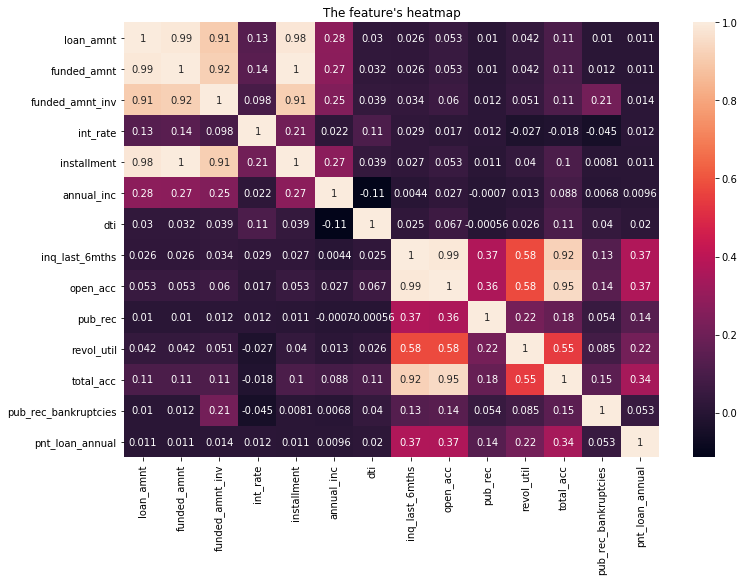

删除特征字段： 5 
 ['loan_amnt', 'total_acc', 'open_acc', 'funded_amnt', 'installment']
原特征字段： 14 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的特征字段： 9 
 ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的所有特征字段： 12 
 ['emp_length', 'purpose', 'addr_state', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']


In [27]:
# 3.2 根据相关性与iv筛选特征(连续性特征)
# 注：相关性高的两个特征(阈值0.7)，可删除iv值较小的特征
# 相关性分析：连续性特征(14个)
sub_num_feature = list(df_s[sel_feature_])[3:]
sub_char_feature = list(df_s[sel_feature_])[0:3]
sn_df = df_s[sub_num_feature].corr()
# 热力图
plot_seaborn(sn_df)
numf_vi = feature_sels_vi[3:].reset_index().drop('index', axis=1)

# 可删除特征字段
del_feature_subs = del_feature_sub(sn_df, numf_vi, th_c=0.7)
print('删除特征字段：', len(del_feature_subs), '\n', del_feature_subs)
print('原特征字段：', len(sub_num_feature), '\n', sub_num_feature)
# 新的连续特征字段
new_num_feature = [i for i in sub_num_feature if i not in del_feature_subs]
print('新的特征字段：',len(new_num_feature), '\n', new_num_feature)
# 新的所有特征字段
all_newFeature_sub = sub_char_feature + new_num_feature
print('新的所有特征字段：',len(all_newFeature_sub), '\n', all_newFeature_sub)

In [28]:
# 3.3 根据多重共线性筛选特征(连续型特征)
# 判断：
#    若VIF<3：说明基本不存在多重共线性的问题；
#    若3<VIF<10：存在一定的多重共线性，实情考虑；
#    若VIF>=10：说明问题比较严重，建议删除特征；
vif_df = df_s[new_num_feature]
print(vif_df.shape)
numF_vif = pd.DataFrame()
numF_vif['feature_name'] = vif_df.columns
numF_vif['vif_v'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print('最大VIF值：max(vif)=%s\n' % max(numF_vif.vif_v))  # max(vif_v)<10，均无多重共线性，不操作
numF_vif

(31534, 9)
最大VIF值：max(vif)=5.8973037330539



,feature_name,vif_v
0,funded_amnt_inv,3.227471
1,int_rate,5.897304
2,annual_inc,2.171382
3,dti,4.108529
4,inq_last_6mths,1.841611
5,pub_rec,1.158956
6,revol_util,1.515761
7,pub_rec_bankruptcies,1.117218
8,pnt_loan_annual,1.159677


# 4.模型建立与评价

In [31]:
# 数据准备_all_newFeature_sub
df_model = df_s[all_newFeature_sub]
df_model[sub_char_feature] = df_model[sub_char_feature].astype('str')
save_file(df_model, 'df_model_new.csv')
print(df_model.shape)

C:\Users\15742\Anaconda35\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(31534, 12)


In [33]:
# ======== 4.1 CatBoost模型 ========

In [34]:
# 训练集和测试集划分：7：3
x_train_cb, x_test_cb, y_train_cb, y_test_cb = train_test_split(df_model, df_s['y'], test_size=0.3, random_state=10)
print(x_train_cb.shape)
print(x_test_cb.shape)
print(y_train_cb.shape)
print(y_test_cb.shape)

(22073, 12)
(9461, 12)
(22073,)
(9461,)


In [36]:
# 模型训练与结果
model_cb = cat_model_run(x_train_cb, y_train_cb)
model_cb.get_params()
model_cb.fit(x_train_cb, y_train_cb)

{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.1, 'loss_function': 'Logloss', 'subsample': 0.7, 'cat_features': [0, 1, 2]}
0:	learn: 0.6390232	total: 405ms	remaining: 3.65s
1:	learn: 0.5949206	total: 432ms	remaining: 1.73s
2:	learn: 0.5574641	total: 449ms	remaining: 1.05s
3:	learn: 0.5265023	total: 461ms	remaining: 691ms
4:	learn: 0.5007500	total: 472ms	remaining: 472ms
5:	learn: 0.4788720	total: 484ms	remaining: 323ms
6:	learn: 0.4605328	total: 498ms	remaining: 213ms
7:	learn: 0.4449321	total: 512ms	remaining: 128ms
8:	learn: 0.4317451	total: 525ms	remaining: 58.3ms
9:	learn: 0.4202584	total: 537ms	remaining: 0us
0:	learn: 0.6388659	total: 16.2ms	remaining: 146ms
1:	learn: 0.5945650	total: 32ms	remaining: 128ms
2:	learn: 0.5576120	total: 48.1ms	remaining: 112ms
3:	learn: 0.5270149	total: 61.2ms	remaining: 91.8ms
4:	learn: 0.5007386	total: 76ms	remaining: 76ms
5:	learn: 0.4787249	total: 87.9ms	remaining: 58.6ms
6:	learn: 0.4600380	total: 100ms	remaining: 42.9ms
7

12:	learn: 0.3950370	total: 230ms	remaining: 654ms
13:	learn: 0.3886336	total: 245ms	remaining: 629ms
14:	learn: 0.3835461	total: 262ms	remaining: 612ms
15:	learn: 0.3787227	total: 275ms	remaining: 584ms
16:	learn: 0.3748470	total: 288ms	remaining: 559ms
17:	learn: 0.3714665	total: 302ms	remaining: 537ms
18:	learn: 0.3687638	total: 315ms	remaining: 514ms
19:	learn: 0.3661700	total: 327ms	remaining: 490ms
20:	learn: 0.3637208	total: 338ms	remaining: 467ms
21:	learn: 0.3616614	total: 355ms	remaining: 452ms
22:	learn: 0.3603981	total: 365ms	remaining: 429ms
23:	learn: 0.3589123	total: 379ms	remaining: 411ms
24:	learn: 0.3575956	total: 404ms	remaining: 404ms
25:	learn: 0.3564457	total: 421ms	remaining: 389ms
26:	learn: 0.3553733	total: 435ms	remaining: 370ms
27:	learn: 0.3544676	total: 451ms	remaining: 354ms
28:	learn: 0.3535736	total: 461ms	remaining: 334ms
29:	learn: 0.3525737	total: 473ms	remaining: 315ms
30:	learn: 0.3517166	total: 490ms	remaining: 300ms
31:	learn: 0.3509387	total: 502

27:	learn: 0.3528576	total: 385ms	remaining: 991ms
28:	learn: 0.3518018	total: 400ms	remaining: 979ms
29:	learn: 0.3508219	total: 411ms	remaining: 959ms
30:	learn: 0.3498553	total: 428ms	remaining: 952ms
31:	learn: 0.3489866	total: 438ms	remaining: 931ms
32:	learn: 0.3481682	total: 452ms	remaining: 918ms
33:	learn: 0.3475800	total: 464ms	remaining: 900ms
34:	learn: 0.3469612	total: 474ms	remaining: 881ms
35:	learn: 0.3465519	total: 487ms	remaining: 867ms
36:	learn: 0.3459724	total: 500ms	remaining: 851ms
37:	learn: 0.3453438	total: 512ms	remaining: 835ms
38:	learn: 0.3450678	total: 524ms	remaining: 819ms
39:	learn: 0.3446247	total: 539ms	remaining: 808ms
40:	learn: 0.3443282	total: 549ms	remaining: 790ms
41:	learn: 0.3438761	total: 567ms	remaining: 783ms
42:	learn: 0.3434213	total: 579ms	remaining: 768ms
43:	learn: 0.3430640	total: 590ms	remaining: 751ms
44:	learn: 0.3427562	total: 601ms	remaining: 734ms
45:	learn: 0.3424038	total: 613ms	remaining: 719ms
46:	learn: 0.3420824	total: 625

95:	learn: 0.3319167	total: 1.28s	remaining: 53.3ms
96:	learn: 0.3316840	total: 1.29s	remaining: 40ms
97:	learn: 0.3314097	total: 1.31s	remaining: 26.7ms
98:	learn: 0.3312393	total: 1.32s	remaining: 13.3ms
99:	learn: 0.3310064	total: 1.33s	remaining: 0us
0:	learn: 0.6384889	total: 17.5ms	remaining: 1.73s
1:	learn: 0.5943068	total: 32.2ms	remaining: 1.58s
2:	learn: 0.5573144	total: 44.6ms	remaining: 1.44s
3:	learn: 0.5271523	total: 55.7ms	remaining: 1.34s
4:	learn: 0.5011560	total: 70.3ms	remaining: 1.34s
5:	learn: 0.4791501	total: 83.6ms	remaining: 1.31s
6:	learn: 0.4606222	total: 95ms	remaining: 1.26s
7:	learn: 0.4447476	total: 109ms	remaining: 1.25s
8:	learn: 0.4319726	total: 121ms	remaining: 1.22s
9:	learn: 0.4203951	total: 134ms	remaining: 1.21s
10:	learn: 0.4105948	total: 147ms	remaining: 1.19s
11:	learn: 0.4022940	total: 158ms	remaining: 1.16s
12:	learn: 0.3950370	total: 169ms	remaining: 1.13s
13:	learn: 0.3886336	total: 182ms	remaining: 1.12s
14:	learn: 0.3835461	total: 200ms	re

62:	learn: 0.3387691	total: 905ms	remaining: 531ms
63:	learn: 0.3385765	total: 919ms	remaining: 517ms
64:	learn: 0.3385158	total: 931ms	remaining: 501ms
65:	learn: 0.3383814	total: 944ms	remaining: 486ms
66:	learn: 0.3381479	total: 956ms	remaining: 471ms
67:	learn: 0.3379371	total: 966ms	remaining: 455ms
68:	learn: 0.3377380	total: 979ms	remaining: 440ms
69:	learn: 0.3375989	total: 990ms	remaining: 424ms
70:	learn: 0.3374479	total: 1s	remaining: 409ms
71:	learn: 0.3371444	total: 1.01s	remaining: 394ms
72:	learn: 0.3369499	total: 1.02s	remaining: 379ms
73:	learn: 0.3368296	total: 1.04s	remaining: 365ms
74:	learn: 0.3367165	total: 1.05s	remaining: 349ms
75:	learn: 0.3366438	total: 1.06s	remaining: 334ms
76:	learn: 0.3364742	total: 1.07s	remaining: 320ms
77:	learn: 0.3362819	total: 1.09s	remaining: 307ms
78:	learn: 0.3361067	total: 1.1s	remaining: 293ms
79:	learn: 0.3359910	total: 1.11s	remaining: 278ms
80:	learn: 0.3357795	total: 1.12s	remaining: 264ms
81:	learn: 0.3356311	total: 1.14s	r

24:	learn: 0.3566248	total: 405ms	remaining: 2.02s
25:	learn: 0.3552918	total: 424ms	remaining: 2.02s
26:	learn: 0.3540651	total: 445ms	remaining: 2.03s
27:	learn: 0.3528576	total: 461ms	remaining: 2.01s
28:	learn: 0.3518018	total: 478ms	remaining: 1.99s
29:	learn: 0.3508219	total: 497ms	remaining: 1.99s
30:	learn: 0.3498553	total: 513ms	remaining: 1.97s
31:	learn: 0.3489866	total: 525ms	remaining: 1.94s
32:	learn: 0.3481682	total: 537ms	remaining: 1.9s
33:	learn: 0.3475800	total: 548ms	remaining: 1.87s
34:	learn: 0.3469612	total: 559ms	remaining: 1.84s
35:	learn: 0.3465519	total: 578ms	remaining: 1.83s
36:	learn: 0.3459724	total: 590ms	remaining: 1.8s
37:	learn: 0.3453438	total: 605ms	remaining: 1.78s
38:	learn: 0.3450678	total: 617ms	remaining: 1.76s
39:	learn: 0.3446247	total: 628ms	remaining: 1.73s
40:	learn: 0.3443282	total: 641ms	remaining: 1.7s
41:	learn: 0.3438761	total: 653ms	remaining: 1.68s
42:	learn: 0.3434213	total: 663ms	remaining: 1.65s
43:	learn: 0.3430640	total: 677ms	

40:	learn: 0.3442263	total: 562ms	remaining: 1.49s
41:	learn: 0.3437594	total: 576ms	remaining: 1.48s
42:	learn: 0.3432606	total: 588ms	remaining: 1.46s
43:	learn: 0.3428620	total: 603ms	remaining: 1.45s
44:	learn: 0.3426252	total: 614ms	remaining: 1.43s
45:	learn: 0.3423658	total: 624ms	remaining: 1.41s
46:	learn: 0.3421587	total: 636ms	remaining: 1.39s
47:	learn: 0.3417059	total: 648ms	remaining: 1.38s
48:	learn: 0.3414287	total: 659ms	remaining: 1.36s
49:	learn: 0.3410955	total: 673ms	remaining: 1.35s
50:	learn: 0.3409683	total: 684ms	remaining: 1.33s
51:	learn: 0.3407867	total: 697ms	remaining: 1.31s
52:	learn: 0.3405972	total: 708ms	remaining: 1.29s
53:	learn: 0.3401465	total: 718ms	remaining: 1.28s
54:	learn: 0.3399767	total: 730ms	remaining: 1.26s
55:	learn: 0.3397832	total: 746ms	remaining: 1.25s
56:	learn: 0.3395242	total: 761ms	remaining: 1.24s
57:	learn: 0.3392285	total: 774ms	remaining: 1.23s
58:	learn: 0.3390373	total: 786ms	remaining: 1.21s
59:	learn: 0.3388116	total: 796

57:	learn: 0.3406437	total: 732ms	remaining: 1.16s
58:	learn: 0.3404405	total: 746ms	remaining: 1.15s
59:	learn: 0.3403094	total: 756ms	remaining: 1.13s
60:	learn: 0.3400672	total: 770ms	remaining: 1.12s
61:	learn: 0.3398930	total: 782ms	remaining: 1.11s
62:	learn: 0.3397423	total: 795ms	remaining: 1.1s
63:	learn: 0.3394109	total: 806ms	remaining: 1.08s
64:	learn: 0.3392429	total: 817ms	remaining: 1.07s
65:	learn: 0.3390232	total: 830ms	remaining: 1.06s
66:	learn: 0.3388283	total: 844ms	remaining: 1.04s
67:	learn: 0.3386651	total: 856ms	remaining: 1.03s
68:	learn: 0.3385125	total: 867ms	remaining: 1.02s
69:	learn: 0.3383252	total: 878ms	remaining: 1s
70:	learn: 0.3381128	total: 895ms	remaining: 995ms
71:	learn: 0.3378776	total: 917ms	remaining: 994ms
72:	learn: 0.3376691	total: 932ms	remaining: 983ms
73:	learn: 0.3374795	total: 943ms	remaining: 969ms
74:	learn: 0.3373846	total: 956ms	remaining: 956ms
75:	learn: 0.3372012	total: 968ms	remaining: 942ms
76:	learn: 0.3371142	total: 981ms	r

73:	learn: 0.3368296	total: 911ms	remaining: 935ms
74:	learn: 0.3367165	total: 923ms	remaining: 923ms
75:	learn: 0.3366438	total: 932ms	remaining: 907ms
76:	learn: 0.3364742	total: 946ms	remaining: 897ms
77:	learn: 0.3362819	total: 961ms	remaining: 887ms
78:	learn: 0.3361067	total: 973ms	remaining: 874ms
79:	learn: 0.3359910	total: 988ms	remaining: 864ms
80:	learn: 0.3357795	total: 999ms	remaining: 851ms
81:	learn: 0.3356311	total: 1.01s	remaining: 837ms
82:	learn: 0.3355329	total: 1.02s	remaining: 824ms
83:	learn: 0.3353603	total: 1.03s	remaining: 811ms
84:	learn: 0.3351667	total: 1.04s	remaining: 797ms
85:	learn: 0.3350143	total: 1.05s	remaining: 784ms
86:	learn: 0.3348332	total: 1.06s	remaining: 770ms
87:	learn: 0.3347062	total: 1.07s	remaining: 758ms
88:	learn: 0.3345351	total: 1.09s	remaining: 748ms
89:	learn: 0.3342938	total: 1.1s	remaining: 735ms
90:	learn: 0.3340700	total: 1.12s	remaining: 724ms
91:	learn: 0.3338583	total: 1.13s	remaining: 711ms
92:	learn: 0.3336062	total: 1.14

86:	learn: 0.3332422	total: 1.09s	remaining: 790ms
87:	learn: 0.3330837	total: 1.1s	remaining: 777ms
88:	learn: 0.3329145	total: 1.11s	remaining: 763ms
89:	learn: 0.3327118	total: 1.13s	remaining: 750ms
90:	learn: 0.3324890	total: 1.14s	remaining: 739ms
91:	learn: 0.3323710	total: 1.15s	remaining: 725ms
92:	learn: 0.3320897	total: 1.16s	remaining: 712ms
93:	learn: 0.3318532	total: 1.17s	remaining: 699ms
94:	learn: 0.3317248	total: 1.18s	remaining: 686ms
95:	learn: 0.3315876	total: 1.2s	remaining: 673ms
96:	learn: 0.3314720	total: 1.21s	remaining: 661ms
97:	learn: 0.3313025	total: 1.22s	remaining: 648ms
98:	learn: 0.3310653	total: 1.23s	remaining: 635ms
99:	learn: 0.3308756	total: 1.25s	remaining: 624ms
100:	learn: 0.3306014	total: 1.26s	remaining: 611ms
101:	learn: 0.3305091	total: 1.28s	remaining: 601ms
102:	learn: 0.3302727	total: 1.29s	remaining: 588ms
103:	learn: 0.3300354	total: 1.3s	remaining: 576ms
104:	learn: 0.3298075	total: 1.31s	remaining: 564ms
105:	learn: 0.3296910	total: 

101:	learn: 0.3279005	total: 4.05s	remaining: 3.89s
102:	learn: 0.3277322	total: 4.09s	remaining: 3.86s
103:	learn: 0.3271883	total: 4.14s	remaining: 3.82s
104:	learn: 0.3268092	total: 4.18s	remaining: 3.78s
105:	learn: 0.3265335	total: 4.22s	remaining: 3.75s
106:	learn: 0.3262812	total: 4.26s	remaining: 3.71s
107:	learn: 0.3260286	total: 4.3s	remaining: 3.67s
108:	learn: 0.3256916	total: 4.35s	remaining: 3.63s
109:	learn: 0.3255170	total: 4.39s	remaining: 3.59s
110:	learn: 0.3252178	total: 4.43s	remaining: 3.55s
111:	learn: 0.3248801	total: 4.48s	remaining: 3.52s
112:	learn: 0.3246504	total: 4.52s	remaining: 3.48s
113:	learn: 0.3245259	total: 4.55s	remaining: 3.44s
114:	learn: 0.3243930	total: 4.6s	remaining: 3.4s
115:	learn: 0.3242402	total: 4.64s	remaining: 3.36s
116:	learn: 0.3239448	total: 4.69s	remaining: 3.33s
117:	learn: 0.3236410	total: 4.73s	remaining: 3.29s
118:	learn: 0.3232992	total: 4.77s	remaining: 3.25s
119:	learn: 0.3230140	total: 4.81s	remaining: 3.21s
120:	learn: 0.3

65:	learn: 0.3346159	total: 2.71s	remaining: 5.51s
66:	learn: 0.3344034	total: 2.75s	remaining: 5.46s
67:	learn: 0.3342853	total: 2.79s	remaining: 5.42s
68:	learn: 0.3342556	total: 2.81s	remaining: 5.33s
69:	learn: 0.3340470	total: 2.84s	remaining: 5.27s
70:	learn: 0.3338697	total: 2.88s	remaining: 5.23s
71:	learn: 0.3337433	total: 2.92s	remaining: 5.19s
72:	learn: 0.3335255	total: 2.95s	remaining: 5.13s
73:	learn: 0.3334199	total: 2.98s	remaining: 5.08s
74:	learn: 0.3332015	total: 3.02s	remaining: 5.04s
75:	learn: 0.3329092	total: 3.06s	remaining: 4.99s
76:	learn: 0.3327194	total: 3.1s	remaining: 4.94s
77:	learn: 0.3324298	total: 3.13s	remaining: 4.9s
78:	learn: 0.3322199	total: 3.17s	remaining: 4.86s
79:	learn: 0.3321085	total: 3.21s	remaining: 4.81s
80:	learn: 0.3319013	total: 3.24s	remaining: 4.76s
81:	learn: 0.3317844	total: 3.28s	remaining: 4.72s
82:	learn: 0.3316630	total: 3.32s	remaining: 4.68s
83:	learn: 0.3313350	total: 3.36s	remaining: 4.64s
84:	learn: 0.3312425	total: 3.39s

26:	learn: 0.3491333	total: 1.05s	remaining: 6.74s
27:	learn: 0.3484929	total: 1.09s	remaining: 6.71s
28:	learn: 0.3480040	total: 1.13s	remaining: 6.67s
29:	learn: 0.3475272	total: 1.17s	remaining: 6.64s
30:	learn: 0.3468420	total: 1.2s	remaining: 6.55s
31:	learn: 0.3464843	total: 1.24s	remaining: 6.51s
32:	learn: 0.3463310	total: 1.27s	remaining: 6.43s
33:	learn: 0.3458267	total: 1.3s	remaining: 6.37s
34:	learn: 0.3454524	total: 1.35s	remaining: 6.35s
35:	learn: 0.3450675	total: 1.38s	remaining: 6.29s
36:	learn: 0.3447044	total: 1.42s	remaining: 6.25s
37:	learn: 0.3441218	total: 1.46s	remaining: 6.21s
38:	learn: 0.3436883	total: 1.5s	remaining: 6.18s
39:	learn: 0.3433973	total: 1.53s	remaining: 6.13s
40:	learn: 0.3430578	total: 1.58s	remaining: 6.12s
41:	learn: 0.3429094	total: 1.6s	remaining: 6.04s
42:	learn: 0.3424362	total: 1.65s	remaining: 6.02s
43:	learn: 0.3420572	total: 1.69s	remaining: 5.98s
44:	learn: 0.3416926	total: 1.73s	remaining: 5.95s
45:	learn: 0.3414797	total: 1.76s	r

190:	learn: 0.3120234	total: 7.81s	remaining: 368ms
191:	learn: 0.3118699	total: 7.85s	remaining: 327ms
192:	learn: 0.3117196	total: 7.89s	remaining: 286ms
193:	learn: 0.3116490	total: 7.93s	remaining: 245ms
194:	learn: 0.3115089	total: 7.98s	remaining: 205ms
195:	learn: 0.3113037	total: 8.03s	remaining: 164ms
196:	learn: 0.3110750	total: 8.07s	remaining: 123ms
197:	learn: 0.3109396	total: 8.11s	remaining: 81.9ms
198:	learn: 0.3106843	total: 8.15s	remaining: 41ms
199:	learn: 0.3104856	total: 8.2s	remaining: 0us
0:	learn: 0.6185041	total: 41.7ms	remaining: 8.29s
1:	learn: 0.5639345	total: 83.7ms	remaining: 8.29s
2:	learn: 0.5186560	total: 125ms	remaining: 8.23s
3:	learn: 0.4848847	total: 170ms	remaining: 8.31s
4:	learn: 0.4578209	total: 206ms	remaining: 8.04s
5:	learn: 0.4369777	total: 256ms	remaining: 8.29s
6:	learn: 0.4195958	total: 298ms	remaining: 8.21s
7:	learn: 0.4064412	total: 335ms	remaining: 8.05s
8:	learn: 0.3959497	total: 374ms	remaining: 7.94s
9:	learn: 0.3889223	total: 389m

151:	learn: 0.3176212	total: 6.07s	remaining: 1.92s
152:	learn: 0.3173951	total: 6.12s	remaining: 1.88s
153:	learn: 0.3172500	total: 6.16s	remaining: 1.84s
154:	learn: 0.3170951	total: 6.2s	remaining: 1.8s
155:	learn: 0.3169719	total: 6.24s	remaining: 1.76s
156:	learn: 0.3167578	total: 6.29s	remaining: 1.72s
157:	learn: 0.3165460	total: 6.33s	remaining: 1.68s
158:	learn: 0.3163713	total: 6.37s	remaining: 1.64s
159:	learn: 0.3162069	total: 6.41s	remaining: 1.6s
160:	learn: 0.3160101	total: 6.45s	remaining: 1.56s
161:	learn: 0.3156446	total: 6.49s	remaining: 1.52s
162:	learn: 0.3154732	total: 6.53s	remaining: 1.48s
163:	learn: 0.3153602	total: 6.56s	remaining: 1.44s
164:	learn: 0.3152052	total: 6.6s	remaining: 1.4s
165:	learn: 0.3150096	total: 6.65s	remaining: 1.36s
166:	learn: 0.3149275	total: 6.68s	remaining: 1.32s
167:	learn: 0.3147382	total: 6.73s	remaining: 1.28s
168:	learn: 0.3145731	total: 6.77s	remaining: 1.24s
169:	learn: 0.3142837	total: 6.8s	remaining: 1.2s
170:	learn: 0.31412

112:	learn: 0.3247518	total: 4.44s	remaining: 3.42s
113:	learn: 0.3246155	total: 4.48s	remaining: 3.38s
114:	learn: 0.3242426	total: 4.53s	remaining: 3.35s
115:	learn: 0.3239963	total: 4.57s	remaining: 3.31s
116:	learn: 0.3236717	total: 4.61s	remaining: 3.27s
117:	learn: 0.3235068	total: 4.66s	remaining: 3.23s
118:	learn: 0.3232245	total: 4.7s	remaining: 3.2s
119:	learn: 0.3230626	total: 4.74s	remaining: 3.16s
120:	learn: 0.3228052	total: 4.78s	remaining: 3.12s
121:	learn: 0.3226411	total: 4.83s	remaining: 3.09s
122:	learn: 0.3224635	total: 4.88s	remaining: 3.05s
123:	learn: 0.3223069	total: 4.92s	remaining: 3.02s
124:	learn: 0.3220868	total: 4.96s	remaining: 2.97s
125:	learn: 0.3218030	total: 4.99s	remaining: 2.93s
126:	learn: 0.3215942	total: 5.03s	remaining: 2.89s
127:	learn: 0.3215273	total: 5.07s	remaining: 2.85s
128:	learn: 0.3212003	total: 5.12s	remaining: 2.82s
129:	learn: 0.3211358	total: 5.16s	remaining: 2.78s
130:	learn: 0.3209494	total: 5.2s	remaining: 2.74s
131:	learn: 0.3

25:	learn: 0.3529722	total: 391ms	remaining: 361ms
26:	learn: 0.3514545	total: 408ms	remaining: 347ms
27:	learn: 0.3502455	total: 425ms	remaining: 334ms
28:	learn: 0.3491417	total: 440ms	remaining: 318ms
29:	learn: 0.3481155	total: 455ms	remaining: 303ms
30:	learn: 0.3471484	total: 468ms	remaining: 287ms
31:	learn: 0.3463247	total: 483ms	remaining: 272ms
32:	learn: 0.3454175	total: 497ms	remaining: 256ms
33:	learn: 0.3451894	total: 505ms	remaining: 238ms
34:	learn: 0.3444751	total: 516ms	remaining: 221ms
35:	learn: 0.3440066	total: 529ms	remaining: 206ms
36:	learn: 0.3434176	total: 544ms	remaining: 191ms
37:	learn: 0.3427735	total: 561ms	remaining: 177ms
38:	learn: 0.3422243	total: 574ms	remaining: 162ms
39:	learn: 0.3418282	total: 592ms	remaining: 148ms
40:	learn: 0.3413126	total: 605ms	remaining: 133ms
41:	learn: 0.3408677	total: 620ms	remaining: 118ms
42:	learn: 0.3404401	total: 632ms	remaining: 103ms
43:	learn: 0.3399220	total: 647ms	remaining: 88.2ms
44:	learn: 0.3395213	total: 66

37:	learn: 0.3438872	total: 572ms	remaining: 181ms
38:	learn: 0.3433189	total: 591ms	remaining: 167ms
39:	learn: 0.3429486	total: 606ms	remaining: 152ms
40:	learn: 0.3424558	total: 621ms	remaining: 136ms
41:	learn: 0.3419451	total: 634ms	remaining: 121ms
42:	learn: 0.3415605	total: 649ms	remaining: 106ms
43:	learn: 0.3410035	total: 664ms	remaining: 90.5ms
44:	learn: 0.3407052	total: 677ms	remaining: 75.3ms
45:	learn: 0.3403954	total: 690ms	remaining: 60ms
46:	learn: 0.3400001	total: 704ms	remaining: 45ms
47:	learn: 0.3398707	total: 712ms	remaining: 29.7ms
48:	learn: 0.3393543	total: 723ms	remaining: 14.8ms
49:	learn: 0.3390181	total: 737ms	remaining: 0us
0:	learn: 0.6384151	total: 20.3ms	remaining: 993ms
1:	learn: 0.5935139	total: 37.8ms	remaining: 906ms
2:	learn: 0.5564833	total: 53.9ms	remaining: 845ms
3:	learn: 0.5253410	total: 73.5ms	remaining: 846ms
4:	learn: 0.4992331	total: 87ms	remaining: 783ms
5:	learn: 0.4773701	total: 105ms	remaining: 767ms
6:	learn: 0.4584145	total: 120ms	r

98:	learn: 0.3238093	total: 1.48s	remaining: 15ms
99:	learn: 0.3234061	total: 1.5s	remaining: 0us
0:	learn: 0.6388510	total: 17.4ms	remaining: 1.73s
1:	learn: 0.5939090	total: 33.8ms	remaining: 1.66s
2:	learn: 0.5567583	total: 47.6ms	remaining: 1.54s
3:	learn: 0.5255251	total: 66.6ms	remaining: 1.6s
4:	learn: 0.4996084	total: 80.8ms	remaining: 1.53s
5:	learn: 0.4777872	total: 93.8ms	remaining: 1.47s
6:	learn: 0.4587019	total: 108ms	remaining: 1.44s
7:	learn: 0.4431372	total: 122ms	remaining: 1.4s
8:	learn: 0.4295756	total: 138ms	remaining: 1.4s
9:	learn: 0.4183222	total: 152ms	remaining: 1.37s
10:	learn: 0.4087400	total: 168ms	remaining: 1.35s
11:	learn: 0.4005320	total: 181ms	remaining: 1.33s
12:	learn: 0.3933230	total: 196ms	remaining: 1.31s
13:	learn: 0.3870925	total: 215ms	remaining: 1.32s
14:	learn: 0.3817199	total: 233ms	remaining: 1.32s
15:	learn: 0.3773406	total: 247ms	remaining: 1.29s
16:	learn: 0.3734138	total: 261ms	remaining: 1.27s
17:	learn: 0.3697429	total: 276ms	remainin

60:	learn: 0.3349678	total: 954ms	remaining: 610ms
61:	learn: 0.3348781	total: 969ms	remaining: 594ms
62:	learn: 0.3346595	total: 985ms	remaining: 578ms
63:	learn: 0.3343576	total: 999ms	remaining: 562ms
64:	learn: 0.3340146	total: 1.01s	remaining: 545ms
65:	learn: 0.3338608	total: 1.02s	remaining: 528ms
66:	learn: 0.3336829	total: 1.04s	remaining: 510ms
67:	learn: 0.3335132	total: 1.05s	remaining: 495ms
68:	learn: 0.3333513	total: 1.07s	remaining: 479ms
69:	learn: 0.3331674	total: 1.08s	remaining: 463ms
70:	learn: 0.3330763	total: 1.09s	remaining: 446ms
71:	learn: 0.3330316	total: 1.1s	remaining: 430ms
72:	learn: 0.3326510	total: 1.12s	remaining: 415ms
73:	learn: 0.3324955	total: 1.14s	remaining: 400ms
74:	learn: 0.3323550	total: 1.15s	remaining: 385ms
75:	learn: 0.3320257	total: 1.17s	remaining: 370ms
76:	learn: 0.3317306	total: 1.19s	remaining: 354ms
77:	learn: 0.3312812	total: 1.2s	remaining: 338ms
78:	learn: 0.3311530	total: 1.21s	remaining: 323ms
79:	learn: 0.3308448	total: 1.23s

25:	learn: 0.3533702	total: 397ms	remaining: 1.13s
26:	learn: 0.3519655	total: 411ms	remaining: 1.11s
27:	learn: 0.3505556	total: 427ms	remaining: 1.1s
28:	learn: 0.3494997	total: 440ms	remaining: 1.08s
29:	learn: 0.3487126	total: 454ms	remaining: 1.06s
30:	learn: 0.3476512	total: 468ms	remaining: 1.04s
31:	learn: 0.3467060	total: 484ms	remaining: 1.03s
32:	learn: 0.3459277	total: 498ms	remaining: 1.01s
33:	learn: 0.3452085	total: 513ms	remaining: 996ms
34:	learn: 0.3444628	total: 532ms	remaining: 988ms
35:	learn: 0.3437633	total: 548ms	remaining: 975ms
36:	learn: 0.3430629	total: 564ms	remaining: 960ms
37:	learn: 0.3424037	total: 587ms	remaining: 958ms
38:	learn: 0.3419273	total: 601ms	remaining: 940ms
39:	learn: 0.3414730	total: 616ms	remaining: 924ms
40:	learn: 0.3410260	total: 628ms	remaining: 904ms
41:	learn: 0.3403966	total: 644ms	remaining: 890ms
42:	learn: 0.3397873	total: 659ms	remaining: 873ms
43:	learn: 0.3392737	total: 675ms	remaining: 859ms
44:	learn: 0.3387912	total: 689m

97:	learn: 0.3241179	total: 1.49s	remaining: 791ms
98:	learn: 0.3238093	total: 1.51s	remaining: 777ms
99:	learn: 0.3234061	total: 1.52s	remaining: 761ms
100:	learn: 0.3231968	total: 1.54s	remaining: 746ms
101:	learn: 0.3229676	total: 1.55s	remaining: 730ms
102:	learn: 0.3226652	total: 1.56s	remaining: 714ms
103:	learn: 0.3223732	total: 1.58s	remaining: 699ms
104:	learn: 0.3221699	total: 1.6s	remaining: 684ms
105:	learn: 0.3218844	total: 1.61s	remaining: 669ms
106:	learn: 0.3216804	total: 1.63s	remaining: 654ms
107:	learn: 0.3214200	total: 1.64s	remaining: 638ms
108:	learn: 0.3211151	total: 1.66s	remaining: 624ms
109:	learn: 0.3208667	total: 1.68s	remaining: 609ms
110:	learn: 0.3206585	total: 1.69s	remaining: 593ms
111:	learn: 0.3204004	total: 1.7s	remaining: 578ms
112:	learn: 0.3201958	total: 1.72s	remaining: 562ms
113:	learn: 0.3200247	total: 1.73s	remaining: 546ms
114:	learn: 0.3198054	total: 1.74s	remaining: 530ms
115:	learn: 0.3195555	total: 1.76s	remaining: 515ms
116:	learn: 0.319

107:	learn: 0.3221389	total: 1.66s	remaining: 644ms
108:	learn: 0.3219955	total: 1.67s	remaining: 628ms
109:	learn: 0.3217423	total: 1.69s	remaining: 613ms
110:	learn: 0.3215586	total: 1.7s	remaining: 597ms
111:	learn: 0.3212734	total: 1.72s	remaining: 582ms
112:	learn: 0.3208794	total: 1.73s	remaining: 567ms
113:	learn: 0.3207721	total: 1.75s	remaining: 551ms
114:	learn: 0.3203631	total: 1.76s	remaining: 536ms
115:	learn: 0.3202379	total: 1.77s	remaining: 520ms
116:	learn: 0.3199653	total: 1.79s	remaining: 505ms
117:	learn: 0.3197469	total: 1.8s	remaining: 489ms
118:	learn: 0.3194673	total: 1.82s	remaining: 473ms
119:	learn: 0.3191647	total: 1.83s	remaining: 458ms
120:	learn: 0.3189975	total: 1.85s	remaining: 445ms
121:	learn: 0.3188168	total: 1.87s	remaining: 429ms
122:	learn: 0.3185714	total: 1.89s	remaining: 414ms
123:	learn: 0.3183231	total: 1.9s	remaining: 399ms
124:	learn: 0.3181664	total: 1.92s	remaining: 383ms
125:	learn: 0.3178568	total: 1.93s	remaining: 368ms
126:	learn: 0.3

118:	learn: 0.3205660	total: 1.82s	remaining: 474ms
119:	learn: 0.3201844	total: 1.84s	remaining: 460ms
120:	learn: 0.3199796	total: 1.85s	remaining: 444ms
121:	learn: 0.3197930	total: 1.87s	remaining: 429ms
122:	learn: 0.3195560	total: 1.89s	remaining: 414ms
123:	learn: 0.3193125	total: 1.9s	remaining: 399ms
124:	learn: 0.3189922	total: 1.92s	remaining: 383ms
125:	learn: 0.3188877	total: 1.93s	remaining: 367ms
126:	learn: 0.3186872	total: 1.94s	remaining: 352ms
127:	learn: 0.3184877	total: 1.95s	remaining: 336ms
128:	learn: 0.3182886	total: 1.97s	remaining: 321ms
129:	learn: 0.3179921	total: 1.98s	remaining: 305ms
130:	learn: 0.3178559	total: 2.01s	remaining: 291ms
131:	learn: 0.3176280	total: 2.03s	remaining: 277ms
132:	learn: 0.3174559	total: 2.04s	remaining: 261ms
133:	learn: 0.3170293	total: 2.06s	remaining: 246ms
134:	learn: 0.3166797	total: 2.07s	remaining: 230ms
135:	learn: 0.3164909	total: 2.08s	remaining: 215ms
136:	learn: 0.3163143	total: 2.1s	remaining: 199ms
137:	learn: 0.

130:	learn: 0.3174526	total: 1.99s	remaining: 289ms
131:	learn: 0.3172027	total: 2.01s	remaining: 274ms
132:	learn: 0.3168092	total: 2.02s	remaining: 259ms
133:	learn: 0.3166024	total: 2.04s	remaining: 244ms
134:	learn: 0.3164224	total: 2.05s	remaining: 228ms
135:	learn: 0.3162347	total: 2.07s	remaining: 213ms
136:	learn: 0.3159484	total: 2.08s	remaining: 197ms
137:	learn: 0.3157838	total: 2.09s	remaining: 182ms
138:	learn: 0.3153928	total: 2.11s	remaining: 167ms
139:	learn: 0.3150734	total: 2.12s	remaining: 152ms
140:	learn: 0.3148172	total: 2.14s	remaining: 136ms
141:	learn: 0.3144873	total: 2.15s	remaining: 121ms
142:	learn: 0.3141661	total: 2.17s	remaining: 106ms
143:	learn: 0.3139118	total: 2.19s	remaining: 91.2ms
144:	learn: 0.3137474	total: 2.2s	remaining: 76ms
145:	learn: 0.3135826	total: 2.22s	remaining: 60.9ms
146:	learn: 0.3133316	total: 2.23s	remaining: 45.6ms
147:	learn: 0.3130896	total: 2.25s	remaining: 30.4ms
148:	learn: 0.3127316	total: 2.27s	remaining: 15.2ms
149:	lear

147:	learn: 0.3111877	total: 2.37s	remaining: 32ms
148:	learn: 0.3109216	total: 2.38s	remaining: 16ms
149:	learn: 0.3107595	total: 2.4s	remaining: 0us
0:	learn: 0.6217807	total: 53.5ms	remaining: 10.7s
1:	learn: 0.5639143	total: 107ms	remaining: 10.6s
2:	learn: 0.5174156	total: 159ms	remaining: 10.4s
3:	learn: 0.4814549	total: 212ms	remaining: 10.4s
4:	learn: 0.4547977	total: 268ms	remaining: 10.4s
5:	learn: 0.4324764	total: 326ms	remaining: 10.6s
6:	learn: 0.4169009	total: 374ms	remaining: 10.3s
7:	learn: 0.4049589	total: 395ms	remaining: 9.49s
8:	learn: 0.3942621	total: 441ms	remaining: 9.36s
9:	learn: 0.3851350	total: 493ms	remaining: 9.37s
10:	learn: 0.3775892	total: 560ms	remaining: 9.62s
11:	learn: 0.3719515	total: 604ms	remaining: 9.46s
12:	learn: 0.3672689	total: 662ms	remaining: 9.52s
13:	learn: 0.3635737	total: 702ms	remaining: 9.33s
14:	learn: 0.3604671	total: 748ms	remaining: 9.23s
15:	learn: 0.3578447	total: 793ms	remaining: 9.12s
16:	learn: 0.3565958	total: 804ms	remainin

158:	learn: 0.2979826	total: 7.83s	remaining: 2.02s
159:	learn: 0.2976719	total: 7.87s	remaining: 1.97s
160:	learn: 0.2974117	total: 7.92s	remaining: 1.92s
161:	learn: 0.2970173	total: 7.96s	remaining: 1.87s
162:	learn: 0.2968316	total: 8.02s	remaining: 1.82s
163:	learn: 0.2962852	total: 8.06s	remaining: 1.77s
164:	learn: 0.2960879	total: 8.11s	remaining: 1.72s
165:	learn: 0.2956915	total: 8.17s	remaining: 1.67s
166:	learn: 0.2954707	total: 8.23s	remaining: 1.63s
167:	learn: 0.2952458	total: 8.28s	remaining: 1.58s
168:	learn: 0.2949621	total: 8.33s	remaining: 1.53s
169:	learn: 0.2945365	total: 8.38s	remaining: 1.48s
170:	learn: 0.2942911	total: 8.44s	remaining: 1.43s
171:	learn: 0.2938298	total: 8.49s	remaining: 1.38s
172:	learn: 0.2936743	total: 8.53s	remaining: 1.33s
173:	learn: 0.2932587	total: 8.58s	remaining: 1.28s
174:	learn: 0.2929910	total: 8.64s	remaining: 1.23s
175:	learn: 0.2928345	total: 8.67s	remaining: 1.18s
176:	learn: 0.2924179	total: 8.72s	remaining: 1.13s
177:	learn: 

123:	learn: 0.3091932	total: 6.02s	remaining: 3.69s
124:	learn: 0.3089020	total: 6.07s	remaining: 3.64s
125:	learn: 0.3086103	total: 6.11s	remaining: 3.59s
126:	learn: 0.3084083	total: 6.17s	remaining: 3.54s
127:	learn: 0.3081550	total: 6.21s	remaining: 3.5s
128:	learn: 0.3076870	total: 6.26s	remaining: 3.44s
129:	learn: 0.3074761	total: 6.29s	remaining: 3.39s
130:	learn: 0.3071324	total: 6.33s	remaining: 3.33s
131:	learn: 0.3068724	total: 6.37s	remaining: 3.28s
132:	learn: 0.3065307	total: 6.42s	remaining: 3.23s
133:	learn: 0.3062990	total: 6.46s	remaining: 3.18s
134:	learn: 0.3060643	total: 6.5s	remaining: 3.13s
135:	learn: 0.3058148	total: 6.55s	remaining: 3.08s
136:	learn: 0.3054361	total: 6.61s	remaining: 3.04s
137:	learn: 0.3051044	total: 6.65s	remaining: 2.99s
138:	learn: 0.3047002	total: 6.71s	remaining: 2.94s
139:	learn: 0.3044650	total: 6.75s	remaining: 2.9s
140:	learn: 0.3040893	total: 6.81s	remaining: 2.85s
141:	learn: 0.3037920	total: 6.85s	remaining: 2.8s
142:	learn: 0.30

84:	learn: 0.3220632	total: 4.15s	remaining: 5.62s
85:	learn: 0.3218195	total: 4.21s	remaining: 5.58s
86:	learn: 0.3214008	total: 4.25s	remaining: 5.52s
87:	learn: 0.3211160	total: 4.3s	remaining: 5.47s
88:	learn: 0.3207356	total: 4.35s	remaining: 5.42s
89:	learn: 0.3203142	total: 4.4s	remaining: 5.38s
90:	learn: 0.3200535	total: 4.46s	remaining: 5.34s
91:	learn: 0.3197734	total: 4.51s	remaining: 5.29s
92:	learn: 0.3195594	total: 4.55s	remaining: 5.24s
93:	learn: 0.3194441	total: 4.6s	remaining: 5.19s
94:	learn: 0.3191651	total: 4.64s	remaining: 5.13s
95:	learn: 0.3189249	total: 4.69s	remaining: 5.08s
96:	learn: 0.3186046	total: 4.73s	remaining: 5.03s
97:	learn: 0.3183342	total: 4.78s	remaining: 4.97s
98:	learn: 0.3181577	total: 4.82s	remaining: 4.92s
99:	learn: 0.3180066	total: 4.88s	remaining: 4.88s
100:	learn: 0.3176658	total: 4.92s	remaining: 4.82s
101:	learn: 0.3173598	total: 4.97s	remaining: 4.78s
102:	learn: 0.3169109	total: 5.02s	remaining: 4.73s
103:	learn: 0.3168117	total: 5.

46:	learn: 0.3340082	total: 2.27s	remaining: 7.41s
47:	learn: 0.3336413	total: 2.33s	remaining: 7.37s
48:	learn: 0.3331411	total: 2.38s	remaining: 7.32s
49:	learn: 0.3327644	total: 2.43s	remaining: 7.28s
50:	learn: 0.3325289	total: 2.48s	remaining: 7.23s
51:	learn: 0.3322759	total: 2.53s	remaining: 7.2s
52:	learn: 0.3318750	total: 2.58s	remaining: 7.15s
53:	learn: 0.3314696	total: 2.63s	remaining: 7.11s
54:	learn: 0.3311569	total: 2.68s	remaining: 7.07s
55:	learn: 0.3308020	total: 2.74s	remaining: 7.04s
56:	learn: 0.3302735	total: 2.79s	remaining: 6.99s
57:	learn: 0.3299845	total: 2.83s	remaining: 6.94s
58:	learn: 0.3296038	total: 2.89s	remaining: 6.91s
59:	learn: 0.3292882	total: 2.94s	remaining: 6.87s
60:	learn: 0.3288067	total: 2.99s	remaining: 6.8s
61:	learn: 0.3284287	total: 3.03s	remaining: 6.75s
62:	learn: 0.3279685	total: 3.08s	remaining: 6.7s
63:	learn: 0.3279420	total: 3.12s	remaining: 6.62s
64:	learn: 0.3276607	total: 3.17s	remaining: 6.58s
65:	learn: 0.3273771	total: 3.22s	

9:	learn: 0.3860866	total: 504ms	remaining: 9.58s
10:	learn: 0.3797134	total: 558ms	remaining: 9.59s
11:	learn: 0.3743350	total: 614ms	remaining: 9.61s
12:	learn: 0.3687152	total: 667ms	remaining: 9.6s
13:	learn: 0.3645009	total: 722ms	remaining: 9.59s
14:	learn: 0.3613421	total: 783ms	remaining: 9.66s
15:	learn: 0.3588227	total: 896ms	remaining: 10.3s
16:	learn: 0.3575606	total: 916ms	remaining: 9.86s
17:	learn: 0.3551288	total: 976ms	remaining: 9.87s
18:	learn: 0.3533118	total: 1.03s	remaining: 9.83s
19:	learn: 0.3518526	total: 1.08s	remaining: 9.69s
20:	learn: 0.3508121	total: 1.13s	remaining: 9.62s
21:	learn: 0.3494473	total: 1.18s	remaining: 9.53s
22:	learn: 0.3482306	total: 1.22s	remaining: 9.42s
23:	learn: 0.3471068	total: 1.27s	remaining: 9.3s
24:	learn: 0.3460221	total: 1.32s	remaining: 9.23s
25:	learn: 0.3452731	total: 1.36s	remaining: 9.09s
26:	learn: 0.3443175	total: 1.41s	remaining: 9.01s
27:	learn: 0.3435496	total: 1.46s	remaining: 8.96s
28:	learn: 0.3425304	total: 1.51s	

169:	learn: 0.2964613	total: 8.52s	remaining: 1.5s
170:	learn: 0.2963039	total: 8.57s	remaining: 1.45s
171:	learn: 0.2961475	total: 8.62s	remaining: 1.4s
172:	learn: 0.2957897	total: 8.67s	remaining: 1.35s
173:	learn: 0.2956207	total: 8.72s	remaining: 1.3s
174:	learn: 0.2953189	total: 8.77s	remaining: 1.25s
175:	learn: 0.2950281	total: 8.82s	remaining: 1.2s
176:	learn: 0.2947148	total: 8.87s	remaining: 1.15s
177:	learn: 0.2943424	total: 8.93s	remaining: 1.1s
178:	learn: 0.2940786	total: 8.98s	remaining: 1.05s
179:	learn: 0.2938483	total: 9.03s	remaining: 1s
180:	learn: 0.2934686	total: 9.08s	remaining: 953ms
181:	learn: 0.2933228	total: 9.13s	remaining: 904ms
182:	learn: 0.2930374	total: 9.19s	remaining: 854ms
183:	learn: 0.2927860	total: 9.23s	remaining: 803ms
184:	learn: 0.2924924	total: 9.28s	remaining: 752ms
185:	learn: 0.2923906	total: 9.31s	remaining: 701ms
186:	learn: 0.2921842	total: 9.36s	remaining: 651ms
187:	learn: 0.2921189	total: 9.41s	remaining: 601ms
188:	learn: 0.291895

36:	learn: 0.3383056	total: 785ms	remaining: 276ms
37:	learn: 0.3376396	total: 802ms	remaining: 253ms
38:	learn: 0.3370093	total: 826ms	remaining: 233ms
39:	learn: 0.3363885	total: 848ms	remaining: 212ms
40:	learn: 0.3356983	total: 866ms	remaining: 190ms
41:	learn: 0.3355137	total: 880ms	remaining: 168ms
42:	learn: 0.3349139	total: 896ms	remaining: 146ms
43:	learn: 0.3342930	total: 921ms	remaining: 126ms
44:	learn: 0.3335951	total: 940ms	remaining: 104ms
45:	learn: 0.3332414	total: 957ms	remaining: 83.2ms
46:	learn: 0.3328323	total: 981ms	remaining: 62.6ms
47:	learn: 0.3324335	total: 1s	remaining: 41.7ms
48:	learn: 0.3318366	total: 1.02s	remaining: 20.9ms
49:	learn: 0.3310323	total: 1.04s	remaining: 0us
0:	learn: 0.6384183	total: 19.2ms	remaining: 940ms
1:	learn: 0.5934384	total: 46.4ms	remaining: 1.11s
2:	learn: 0.5562730	total: 70.1ms	remaining: 1.1s
3:	learn: 0.5255228	total: 93.6ms	remaining: 1.08s
4:	learn: 0.4995535	total: 109ms	remaining: 982ms
5:	learn: 0.4772993	total: 131ms	r

49:	learn: 0.3342376	total: 970ms	remaining: 0us
0:	learn: 0.6389788	total: 22.7ms	remaining: 2.25s
1:	learn: 0.5937047	total: 46.5ms	remaining: 2.28s
2:	learn: 0.5566450	total: 65.5ms	remaining: 2.12s
3:	learn: 0.5249389	total: 85.4ms	remaining: 2.05s
4:	learn: 0.4990264	total: 108ms	remaining: 2.06s
5:	learn: 0.4770879	total: 128ms	remaining: 2.01s
6:	learn: 0.4580716	total: 148ms	remaining: 1.97s
7:	learn: 0.4416550	total: 168ms	remaining: 1.94s
8:	learn: 0.4280612	total: 188ms	remaining: 1.9s
9:	learn: 0.4160968	total: 206ms	remaining: 1.85s
10:	learn: 0.4059041	total: 232ms	remaining: 1.88s
11:	learn: 0.3975104	total: 251ms	remaining: 1.84s
12:	learn: 0.3902143	total: 269ms	remaining: 1.8s
13:	learn: 0.3841481	total: 290ms	remaining: 1.78s
14:	learn: 0.3787459	total: 308ms	remaining: 1.74s
15:	learn: 0.3746295	total: 329ms	remaining: 1.73s
16:	learn: 0.3706701	total: 350ms	remaining: 1.71s
17:	learn: 0.3670600	total: 373ms	remaining: 1.7s
18:	learn: 0.3637387	total: 390ms	remainin

63:	learn: 0.3250115	total: 1.31s	remaining: 738ms
64:	learn: 0.3245855	total: 1.33s	remaining: 717ms
65:	learn: 0.3240670	total: 1.35s	remaining: 696ms
66:	learn: 0.3237096	total: 1.37s	remaining: 677ms
67:	learn: 0.3234076	total: 1.39s	remaining: 656ms
68:	learn: 0.3231090	total: 1.41s	remaining: 635ms
69:	learn: 0.3228208	total: 1.43s	remaining: 614ms
70:	learn: 0.3225642	total: 1.45s	remaining: 594ms
71:	learn: 0.3225253	total: 1.46s	remaining: 570ms
72:	learn: 0.3222038	total: 1.48s	remaining: 549ms
73:	learn: 0.3218406	total: 1.5s	remaining: 528ms
74:	learn: 0.3215841	total: 1.52s	remaining: 508ms
75:	learn: 0.3210760	total: 1.54s	remaining: 487ms
76:	learn: 0.3207452	total: 1.56s	remaining: 467ms
77:	learn: 0.3206100	total: 1.58s	remaining: 447ms
78:	learn: 0.3202898	total: 1.6s	remaining: 426ms
79:	learn: 0.3199988	total: 1.62s	remaining: 405ms
80:	learn: 0.3198058	total: 1.64s	remaining: 385ms
81:	learn: 0.3195166	total: 1.66s	remaining: 364ms
82:	learn: 0.3193125	total: 1.68s

25:	learn: 0.3504612	total: 583ms	remaining: 1.66s
26:	learn: 0.3490374	total: 604ms	remaining: 1.63s
27:	learn: 0.3477165	total: 624ms	remaining: 1.6s
28:	learn: 0.3468123	total: 645ms	remaining: 1.58s
29:	learn: 0.3455177	total: 666ms	remaining: 1.55s
30:	learn: 0.3442673	total: 691ms	remaining: 1.54s
31:	learn: 0.3436022	total: 711ms	remaining: 1.51s
32:	learn: 0.3427928	total: 732ms	remaining: 1.49s
33:	learn: 0.3418273	total: 794ms	remaining: 1.54s
34:	learn: 0.3409355	total: 835ms	remaining: 1.55s
35:	learn: 0.3400132	total: 861ms	remaining: 1.53s
36:	learn: 0.3392202	total: 879ms	remaining: 1.5s
37:	learn: 0.3387308	total: 906ms	remaining: 1.48s
38:	learn: 0.3380489	total: 928ms	remaining: 1.45s
39:	learn: 0.3375892	total: 954ms	remaining: 1.43s
40:	learn: 0.3368784	total: 974ms	remaining: 1.4s
41:	learn: 0.3364118	total: 994ms	remaining: 1.37s
42:	learn: 0.3359437	total: 1.02s	remaining: 1.35s
43:	learn: 0.3352149	total: 1.04s	remaining: 1.33s
44:	learn: 0.3344205	total: 1.07s	

95:	learn: 0.3171150	total: 1.89s	remaining: 78.6ms
96:	learn: 0.3166204	total: 1.91s	remaining: 59ms
97:	learn: 0.3163207	total: 1.94s	remaining: 39.5ms
98:	learn: 0.3158757	total: 1.97s	remaining: 19.9ms
99:	learn: 0.3155882	total: 1.98s	remaining: 0us
0:	learn: 0.6389788	total: 21.6ms	remaining: 3.21s
1:	learn: 0.5937047	total: 41.7ms	remaining: 3.08s
2:	learn: 0.5566450	total: 60.3ms	remaining: 2.96s
3:	learn: 0.5249389	total: 79.4ms	remaining: 2.9s
4:	learn: 0.4990264	total: 102ms	remaining: 2.95s
5:	learn: 0.4770879	total: 120ms	remaining: 2.88s
6:	learn: 0.4580716	total: 139ms	remaining: 2.84s
7:	learn: 0.4416550	total: 158ms	remaining: 2.8s
8:	learn: 0.4280612	total: 178ms	remaining: 2.79s
9:	learn: 0.4160968	total: 196ms	remaining: 2.74s
10:	learn: 0.4059041	total: 221ms	remaining: 2.79s
11:	learn: 0.3975104	total: 245ms	remaining: 2.82s
12:	learn: 0.3902143	total: 265ms	remaining: 2.79s
13:	learn: 0.3841481	total: 288ms	remaining: 2.79s
14:	learn: 0.3787459	total: 305ms	remai

10:	learn: 0.4077997	total: 216ms	remaining: 2.73s
11:	learn: 0.3994144	total: 238ms	remaining: 2.73s
12:	learn: 0.3918758	total: 259ms	remaining: 2.73s
13:	learn: 0.3850722	total: 278ms	remaining: 2.7s
14:	learn: 0.3799234	total: 296ms	remaining: 2.67s
15:	learn: 0.3749544	total: 319ms	remaining: 2.67s
16:	learn: 0.3710335	total: 337ms	remaining: 2.63s
17:	learn: 0.3670692	total: 356ms	remaining: 2.61s
18:	learn: 0.3636145	total: 377ms	remaining: 2.6s
19:	learn: 0.3613958	total: 390ms	remaining: 2.54s
20:	learn: 0.3590781	total: 413ms	remaining: 2.54s
21:	learn: 0.3568587	total: 432ms	remaining: 2.51s
22:	learn: 0.3546479	total: 451ms	remaining: 2.49s
23:	learn: 0.3528382	total: 472ms	remaining: 2.48s
24:	learn: 0.3515167	total: 491ms	remaining: 2.45s
25:	learn: 0.3498564	total: 512ms	remaining: 2.44s
26:	learn: 0.3484917	total: 530ms	remaining: 2.42s
27:	learn: 0.3472538	total: 549ms	remaining: 2.39s
28:	learn: 0.3460962	total: 570ms	remaining: 2.38s
29:	learn: 0.3448713	total: 593ms

29:	learn: 0.3460316	total: 600ms	remaining: 2.4s
30:	learn: 0.3450368	total: 622ms	remaining: 2.39s
31:	learn: 0.3443020	total: 648ms	remaining: 2.39s
32:	learn: 0.3433103	total: 671ms	remaining: 2.38s
33:	learn: 0.3423207	total: 691ms	remaining: 2.36s
34:	learn: 0.3415351	total: 710ms	remaining: 2.33s
35:	learn: 0.3406066	total: 730ms	remaining: 2.31s
36:	learn: 0.3399886	total: 749ms	remaining: 2.29s
37:	learn: 0.3391416	total: 770ms	remaining: 2.27s
38:	learn: 0.3386384	total: 789ms	remaining: 2.24s
39:	learn: 0.3378793	total: 810ms	remaining: 2.23s
40:	learn: 0.3373624	total: 832ms	remaining: 2.21s
41:	learn: 0.3366086	total: 850ms	remaining: 2.19s
42:	learn: 0.3363685	total: 869ms	remaining: 2.16s
43:	learn: 0.3356249	total: 892ms	remaining: 2.15s
44:	learn: 0.3352603	total: 912ms	remaining: 2.13s
45:	learn: 0.3345868	total: 935ms	remaining: 2.11s
46:	learn: 0.3341033	total: 960ms	remaining: 2.1s
47:	learn: 0.3336471	total: 980ms	remaining: 2.08s
48:	learn: 0.3333886	total: 999ms

47:	learn: 0.3330082	total: 967ms	remaining: 2.05s
48:	learn: 0.3327273	total: 989ms	remaining: 2.04s
49:	learn: 0.3322761	total: 1.01s	remaining: 2.02s
50:	learn: 0.3320392	total: 1.03s	remaining: 2s
51:	learn: 0.3315761	total: 1.05s	remaining: 1.98s
52:	learn: 0.3309351	total: 1.07s	remaining: 1.95s
53:	learn: 0.3305157	total: 1.08s	remaining: 1.93s
54:	learn: 0.3301453	total: 1.1s	remaining: 1.91s
55:	learn: 0.3301007	total: 1.12s	remaining: 1.87s
56:	learn: 0.3297484	total: 1.14s	remaining: 1.86s
57:	learn: 0.3294292	total: 1.16s	remaining: 1.84s
58:	learn: 0.3290505	total: 1.18s	remaining: 1.82s
59:	learn: 0.3284199	total: 1.2s	remaining: 1.8s
60:	learn: 0.3280885	total: 1.22s	remaining: 1.78s
61:	learn: 0.3280700	total: 1.23s	remaining: 1.74s
62:	learn: 0.3276368	total: 1.24s	remaining: 1.72s
63:	learn: 0.3272290	total: 1.26s	remaining: 1.69s
64:	learn: 0.3269276	total: 1.28s	remaining: 1.67s
65:	learn: 0.3267421	total: 1.3s	remaining: 1.65s
66:	learn: 0.3261972	total: 1.32s	rema

65:	learn: 0.3278867	total: 1.34s	remaining: 1.7s
66:	learn: 0.3277186	total: 1.36s	remaining: 1.68s
67:	learn: 0.3271466	total: 1.38s	remaining: 1.66s
68:	learn: 0.3269102	total: 1.4s	remaining: 1.64s
69:	learn: 0.3266405	total: 1.42s	remaining: 1.62s
70:	learn: 0.3262966	total: 1.44s	remaining: 1.6s
71:	learn: 0.3258673	total: 1.46s	remaining: 1.58s
72:	learn: 0.3256995	total: 1.48s	remaining: 1.56s
73:	learn: 0.3252736	total: 1.5s	remaining: 1.53s
74:	learn: 0.3246826	total: 1.52s	remaining: 1.52s
75:	learn: 0.3242747	total: 1.54s	remaining: 1.5s
76:	learn: 0.3239564	total: 1.56s	remaining: 1.48s
77:	learn: 0.3238305	total: 1.58s	remaining: 1.46s
78:	learn: 0.3237085	total: 1.6s	remaining: 1.44s
79:	learn: 0.3231679	total: 1.62s	remaining: 1.42s
80:	learn: 0.3228745	total: 1.64s	remaining: 1.39s
81:	learn: 0.3226083	total: 1.66s	remaining: 1.37s
82:	learn: 0.3226083	total: 1.67s	remaining: 1.34s
83:	learn: 0.3220176	total: 1.68s	remaining: 1.32s
84:	learn: 0.3217567	total: 1.7s	rema

79:	learn: 0.3114422	total: 4.52s	remaining: 6.79s
80:	learn: 0.3110522	total: 4.58s	remaining: 6.74s
81:	learn: 0.3107849	total: 4.63s	remaining: 6.67s
82:	learn: 0.3104449	total: 4.7s	remaining: 6.63s
83:	learn: 0.3098372	total: 4.76s	remaining: 6.58s
84:	learn: 0.3094777	total: 4.83s	remaining: 6.53s
85:	learn: 0.3090541	total: 4.9s	remaining: 6.5s
86:	learn: 0.3087762	total: 4.96s	remaining: 6.44s
87:	learn: 0.3082218	total: 5.02s	remaining: 6.39s
88:	learn: 0.3079019	total: 5.08s	remaining: 6.33s
89:	learn: 0.3076077	total: 5.12s	remaining: 6.26s
90:	learn: 0.3073495	total: 5.17s	remaining: 6.19s
91:	learn: 0.3069312	total: 5.24s	remaining: 6.15s
92:	learn: 0.3065422	total: 5.3s	remaining: 6.1s
93:	learn: 0.3061752	total: 5.36s	remaining: 6.05s
94:	learn: 0.3056028	total: 5.42s	remaining: 5.99s
95:	learn: 0.3053875	total: 5.49s	remaining: 5.95s
96:	learn: 0.3050270	total: 5.55s	remaining: 5.89s
97:	learn: 0.3045220	total: 5.6s	remaining: 5.83s
98:	learn: 0.3041471	total: 5.67s	rem

40:	learn: 0.3302875	total: 2.22s	remaining: 8.62s
41:	learn: 0.3297458	total: 2.27s	remaining: 8.54s
42:	learn: 0.3297068	total: 2.29s	remaining: 8.36s
43:	learn: 0.3288839	total: 2.34s	remaining: 8.31s
44:	learn: 0.3283750	total: 2.4s	remaining: 8.28s
45:	learn: 0.3283395	total: 2.42s	remaining: 8.12s
46:	learn: 0.3275915	total: 2.48s	remaining: 8.08s
47:	learn: 0.3271311	total: 2.54s	remaining: 8.05s
48:	learn: 0.3264831	total: 2.6s	remaining: 8.01s
49:	learn: 0.3257226	total: 2.67s	remaining: 8.01s
50:	learn: 0.3250410	total: 2.73s	remaining: 7.97s
51:	learn: 0.3242867	total: 2.78s	remaining: 7.92s
52:	learn: 0.3236323	total: 2.85s	remaining: 7.9s
53:	learn: 0.3232693	total: 2.9s	remaining: 7.84s
54:	learn: 0.3230375	total: 2.96s	remaining: 7.81s
55:	learn: 0.3229242	total: 3s	remaining: 7.73s
56:	learn: 0.3229128	total: 3.03s	remaining: 7.59s
57:	learn: 0.3223952	total: 3.08s	remaining: 7.54s
58:	learn: 0.3217745	total: 3.15s	remaining: 7.53s
59:	learn: 0.3208992	total: 3.22s	rema

0:	learn: 0.6164812	total: 67ms	remaining: 13.3s
1:	learn: 0.5569375	total: 141ms	remaining: 13.9s
2:	learn: 0.5150819	total: 184ms	remaining: 12.1s
3:	learn: 0.4828177	total: 223ms	remaining: 10.9s
4:	learn: 0.4561212	total: 293ms	remaining: 11.4s
5:	learn: 0.4360964	total: 348ms	remaining: 11.2s
6:	learn: 0.4176899	total: 417ms	remaining: 11.5s
7:	learn: 0.4052294	total: 450ms	remaining: 10.8s
8:	learn: 0.3925101	total: 522ms	remaining: 11.1s
9:	learn: 0.3853833	total: 560ms	remaining: 10.6s
10:	learn: 0.3771925	total: 627ms	remaining: 10.8s
11:	learn: 0.3715262	total: 693ms	remaining: 10.9s
12:	learn: 0.3677029	total: 720ms	remaining: 10.4s
13:	learn: 0.3635804	total: 773ms	remaining: 10.3s
14:	learn: 0.3605083	total: 831ms	remaining: 10.3s
15:	learn: 0.3576689	total: 889ms	remaining: 10.2s
16:	learn: 0.3555531	total: 948ms	remaining: 10.2s
17:	learn: 0.3536148	total: 1s	remaining: 10.1s
18:	learn: 0.3516701	total: 1.06s	remaining: 10.1s
19:	learn: 0.3495555	total: 1.13s	remaining: 

161:	learn: 0.2768885	total: 9.9s	remaining: 2.32s
162:	learn: 0.2765331	total: 9.96s	remaining: 2.26s
163:	learn: 0.2762041	total: 10s	remaining: 2.2s
164:	learn: 0.2758731	total: 10.1s	remaining: 2.14s
165:	learn: 0.2754144	total: 10.2s	remaining: 2.08s
166:	learn: 0.2748235	total: 10.2s	remaining: 2.02s
167:	learn: 0.2743757	total: 10.3s	remaining: 1.96s
168:	learn: 0.2741864	total: 10.4s	remaining: 1.9s
169:	learn: 0.2738607	total: 10.4s	remaining: 1.84s
170:	learn: 0.2736385	total: 10.5s	remaining: 1.78s
171:	learn: 0.2731824	total: 10.5s	remaining: 1.72s
172:	learn: 0.2728619	total: 10.6s	remaining: 1.66s
173:	learn: 0.2723732	total: 10.7s	remaining: 1.59s
174:	learn: 0.2723037	total: 10.7s	remaining: 1.53s
175:	learn: 0.2717597	total: 10.8s	remaining: 1.47s
176:	learn: 0.2714791	total: 10.8s	remaining: 1.41s
177:	learn: 0.2709394	total: 10.9s	remaining: 1.35s
178:	learn: 0.2704783	total: 11s	remaining: 1.29s
179:	learn: 0.2700572	total: 11s	remaining: 1.23s
180:	learn: 0.2698731

124:	learn: 0.2888021	total: 7.36s	remaining: 4.41s
125:	learn: 0.2880777	total: 7.42s	remaining: 4.36s
126:	learn: 0.2877349	total: 7.48s	remaining: 4.3s
127:	learn: 0.2874423	total: 7.54s	remaining: 4.24s
128:	learn: 0.2868624	total: 7.6s	remaining: 4.18s
129:	learn: 0.2863379	total: 7.66s	remaining: 4.13s
130:	learn: 0.2859563	total: 7.72s	remaining: 4.07s
131:	learn: 0.2853510	total: 7.79s	remaining: 4.01s
132:	learn: 0.2850203	total: 7.85s	remaining: 3.95s
133:	learn: 0.2846854	total: 7.91s	remaining: 3.9s
134:	learn: 0.2841591	total: 7.97s	remaining: 3.84s
135:	learn: 0.2839052	total: 8.03s	remaining: 3.78s
136:	learn: 0.2833024	total: 8.1s	remaining: 3.72s
137:	learn: 0.2830530	total: 8.16s	remaining: 3.66s
138:	learn: 0.2826681	total: 8.22s	remaining: 3.61s
139:	learn: 0.2821647	total: 8.28s	remaining: 3.55s
140:	learn: 0.2816208	total: 8.34s	remaining: 3.49s
141:	learn: 0.2811912	total: 8.4s	remaining: 3.43s
142:	learn: 0.2809998	total: 8.47s	remaining: 3.38s
143:	learn: 0.280

87:	learn: 0.3084108	total: 5.16s	remaining: 6.57s
88:	learn: 0.3079586	total: 5.23s	remaining: 6.52s
89:	learn: 0.3073909	total: 5.29s	remaining: 6.47s
90:	learn: 0.3071973	total: 5.35s	remaining: 6.41s
91:	learn: 0.3068287	total: 5.42s	remaining: 6.36s
92:	learn: 0.3060723	total: 5.48s	remaining: 6.31s
93:	learn: 0.3057240	total: 5.55s	remaining: 6.26s
94:	learn: 0.3052229	total: 5.61s	remaining: 6.2s
95:	learn: 0.3048577	total: 5.68s	remaining: 6.15s
96:	learn: 0.3045541	total: 5.75s	remaining: 6.11s
97:	learn: 0.3041465	total: 5.82s	remaining: 6.05s
98:	learn: 0.3038011	total: 5.88s	remaining: 5.99s
99:	learn: 0.3030208	total: 5.94s	remaining: 5.94s
100:	learn: 0.3026743	total: 5.99s	remaining: 5.88s
101:	learn: 0.3020972	total: 6.06s	remaining: 5.82s
102:	learn: 0.3017291	total: 6.12s	remaining: 5.77s
103:	learn: 0.3014443	total: 6.2s	remaining: 5.72s
104:	learn: 0.3009598	total: 6.25s	remaining: 5.66s
105:	learn: 0.3004806	total: 6.32s	remaining: 5.61s
106:	learn: 0.3001754	total

8:	learn: 0.4284580	total: 253ms	remaining: 28.1ms
9:	learn: 0.4166760	total: 280ms	remaining: 0us
0:	learn: 0.6389477	total: 26.6ms	remaining: 1.3s
1:	learn: 0.5935866	total: 55.8ms	remaining: 1.34s
2:	learn: 0.5563945	total: 88.6ms	remaining: 1.39s
3:	learn: 0.5245137	total: 115ms	remaining: 1.33s
4:	learn: 0.4985583	total: 132ms	remaining: 1.19s
5:	learn: 0.4765786	total: 156ms	remaining: 1.15s
6:	learn: 0.4574684	total: 186ms	remaining: 1.15s
7:	learn: 0.4414573	total: 209ms	remaining: 1.1s
8:	learn: 0.4276016	total: 246ms	remaining: 1.12s
9:	learn: 0.4156377	total: 278ms	remaining: 1.11s
10:	learn: 0.4052410	total: 305ms	remaining: 1.08s
11:	learn: 0.3966653	total: 334ms	remaining: 1.06s
12:	learn: 0.3893221	total: 361ms	remaining: 1.03s
13:	learn: 0.3824852	total: 386ms	remaining: 993ms
14:	learn: 0.3772862	total: 418ms	remaining: 976ms
15:	learn: 0.3721069	total: 445ms	remaining: 946ms
16:	learn: 0.3678394	total: 473ms	remaining: 919ms
17:	learn: 0.3647084	total: 495ms	remaining

15:	learn: 0.3734676	total: 441ms	remaining: 936ms
16:	learn: 0.3690174	total: 470ms	remaining: 912ms
17:	learn: 0.3651681	total: 498ms	remaining: 884ms
18:	learn: 0.3621726	total: 523ms	remaining: 853ms
19:	learn: 0.3591651	total: 555ms	remaining: 832ms
20:	learn: 0.3561560	total: 582ms	remaining: 804ms
21:	learn: 0.3540508	total: 614ms	remaining: 781ms
22:	learn: 0.3518336	total: 645ms	remaining: 757ms
23:	learn: 0.3499170	total: 673ms	remaining: 729ms
24:	learn: 0.3481582	total: 702ms	remaining: 702ms
25:	learn: 0.3463799	total: 728ms	remaining: 672ms
26:	learn: 0.3442296	total: 756ms	remaining: 644ms
27:	learn: 0.3427950	total: 785ms	remaining: 617ms
28:	learn: 0.3416980	total: 819ms	remaining: 593ms
29:	learn: 0.3402710	total: 851ms	remaining: 567ms
30:	learn: 0.3400384	total: 862ms	remaining: 528ms
31:	learn: 0.3391223	total: 884ms	remaining: 497ms
32:	learn: 0.3384595	total: 912ms	remaining: 470ms
33:	learn: 0.3377614	total: 940ms	remaining: 442ms
34:	learn: 0.3369063	total: 966

77:	learn: 0.3065585	total: 2.17s	remaining: 614ms
78:	learn: 0.3058527	total: 2.2s	remaining: 585ms
79:	learn: 0.3051569	total: 2.23s	remaining: 557ms
80:	learn: 0.3048436	total: 2.25s	remaining: 529ms
81:	learn: 0.3045414	total: 2.28s	remaining: 501ms
82:	learn: 0.3038978	total: 2.31s	remaining: 472ms
83:	learn: 0.3034476	total: 2.33s	remaining: 444ms
84:	learn: 0.3030876	total: 2.37s	remaining: 418ms
85:	learn: 0.3029204	total: 2.39s	remaining: 389ms
86:	learn: 0.3028086	total: 2.42s	remaining: 362ms
87:	learn: 0.3023590	total: 2.45s	remaining: 334ms
88:	learn: 0.3020506	total: 2.48s	remaining: 306ms
89:	learn: 0.3013646	total: 2.5s	remaining: 278ms
90:	learn: 0.3010635	total: 2.53s	remaining: 250ms
91:	learn: 0.3003387	total: 2.56s	remaining: 223ms
92:	learn: 0.3001607	total: 2.59s	remaining: 195ms
93:	learn: 0.2995397	total: 2.61s	remaining: 167ms
94:	learn: 0.2992429	total: 2.64s	remaining: 139ms
95:	learn: 0.2989294	total: 2.67s	remaining: 111ms
96:	learn: 0.2982397	total: 2.7s	

44:	learn: 0.3311672	total: 1.21s	remaining: 1.47s
45:	learn: 0.3309687	total: 1.24s	remaining: 1.45s
46:	learn: 0.3301225	total: 1.27s	remaining: 1.43s
47:	learn: 0.3289899	total: 1.29s	remaining: 1.4s
48:	learn: 0.3283710	total: 1.32s	remaining: 1.37s
49:	learn: 0.3272059	total: 1.35s	remaining: 1.35s
50:	learn: 0.3265792	total: 1.38s	remaining: 1.32s
51:	learn: 0.3261486	total: 1.4s	remaining: 1.29s
52:	learn: 0.3258284	total: 1.43s	remaining: 1.27s
53:	learn: 0.3253946	total: 1.46s	remaining: 1.24s
54:	learn: 0.3245689	total: 1.49s	remaining: 1.22s
55:	learn: 0.3240682	total: 1.52s	remaining: 1.19s
56:	learn: 0.3237480	total: 1.55s	remaining: 1.17s
57:	learn: 0.3229232	total: 1.58s	remaining: 1.14s
58:	learn: 0.3225615	total: 1.6s	remaining: 1.11s
59:	learn: 0.3220266	total: 1.64s	remaining: 1.09s
60:	learn: 0.3216633	total: 1.66s	remaining: 1.06s
61:	learn: 0.3209491	total: 1.69s	remaining: 1.04s
62:	learn: 0.3205734	total: 1.72s	remaining: 1.01s
63:	learn: 0.3203668	total: 1.75s	

8:	learn: 0.4284580	total: 257ms	remaining: 2.6s
9:	learn: 0.4166760	total: 300ms	remaining: 2.7s
10:	learn: 0.4063934	total: 328ms	remaining: 2.65s
11:	learn: 0.3982837	total: 348ms	remaining: 2.55s
12:	learn: 0.3905497	total: 382ms	remaining: 2.55s
13:	learn: 0.3834309	total: 408ms	remaining: 2.51s
14:	learn: 0.3781749	total: 436ms	remaining: 2.47s
15:	learn: 0.3729551	total: 461ms	remaining: 2.42s
16:	learn: 0.3687312	total: 489ms	remaining: 2.39s
17:	learn: 0.3648237	total: 515ms	remaining: 2.35s
18:	learn: 0.3613839	total: 541ms	remaining: 2.3s
19:	learn: 0.3582418	total: 568ms	remaining: 2.27s
20:	learn: 0.3553304	total: 592ms	remaining: 2.23s
21:	learn: 0.3532921	total: 627ms	remaining: 2.22s
22:	learn: 0.3516244	total: 664ms	remaining: 2.22s
23:	learn: 0.3496792	total: 689ms	remaining: 2.18s
24:	learn: 0.3486000	total: 705ms	remaining: 2.12s
25:	learn: 0.3475350	total: 721ms	remaining: 2.05s
26:	learn: 0.3462231	total: 746ms	remaining: 2.02s
27:	learn: 0.3447340	total: 772ms	re

74:	learn: 0.3080401	total: 2.74s	remaining: 2.74s
75:	learn: 0.3077800	total: 2.78s	remaining: 2.71s
76:	learn: 0.3071142	total: 2.81s	remaining: 2.67s
77:	learn: 0.3065585	total: 2.85s	remaining: 2.63s
78:	learn: 0.3058527	total: 2.88s	remaining: 2.59s
79:	learn: 0.3051569	total: 2.91s	remaining: 2.55s
80:	learn: 0.3048436	total: 2.96s	remaining: 2.52s
81:	learn: 0.3045414	total: 2.99s	remaining: 2.48s
82:	learn: 0.3038978	total: 3.04s	remaining: 2.45s
83:	learn: 0.3034476	total: 3.07s	remaining: 2.41s
84:	learn: 0.3030876	total: 3.11s	remaining: 2.38s
85:	learn: 0.3029204	total: 3.14s	remaining: 2.34s
86:	learn: 0.3028086	total: 3.18s	remaining: 2.3s
87:	learn: 0.3023590	total: 3.22s	remaining: 2.27s
88:	learn: 0.3020506	total: 3.25s	remaining: 2.23s
89:	learn: 0.3013646	total: 3.28s	remaining: 2.19s
90:	learn: 0.3010635	total: 3.32s	remaining: 2.15s
91:	learn: 0.3003387	total: 3.36s	remaining: 2.12s
92:	learn: 0.3001607	total: 3.39s	remaining: 2.08s
93:	learn: 0.2995397	total: 3.42

86:	learn: 0.3060288	total: 2.93s	remaining: 2.12s
87:	learn: 0.3056928	total: 2.96s	remaining: 2.09s
88:	learn: 0.3054483	total: 2.99s	remaining: 2.05s
89:	learn: 0.3052362	total: 3.03s	remaining: 2.02s
90:	learn: 0.3047957	total: 3.06s	remaining: 1.99s
91:	learn: 0.3041797	total: 3.11s	remaining: 1.96s
92:	learn: 0.3038080	total: 3.15s	remaining: 1.93s
93:	learn: 0.3030921	total: 3.17s	remaining: 1.89s
94:	learn: 0.3026594	total: 3.2s	remaining: 1.85s
95:	learn: 0.3024192	total: 3.23s	remaining: 1.82s
96:	learn: 0.3021122	total: 3.27s	remaining: 1.78s
97:	learn: 0.3016352	total: 3.29s	remaining: 1.75s
98:	learn: 0.3009138	total: 3.33s	remaining: 1.72s
99:	learn: 0.3001748	total: 3.36s	remaining: 1.68s
100:	learn: 0.3000649	total: 3.39s	remaining: 1.65s
101:	learn: 0.2994062	total: 3.42s	remaining: 1.61s
102:	learn: 0.2993560	total: 3.44s	remaining: 1.57s
103:	learn: 0.2989424	total: 3.47s	remaining: 1.53s
104:	learn: 0.2986943	total: 3.5s	remaining: 1.5s
105:	learn: 0.2982333	total: 

103:	learn: 0.3007168	total: 3.48s	remaining: 1.54s
104:	learn: 0.3002941	total: 3.51s	remaining: 1.5s
105:	learn: 0.2998242	total: 3.55s	remaining: 1.48s
106:	learn: 0.2994699	total: 3.6s	remaining: 1.45s
107:	learn: 0.2987750	total: 3.64s	remaining: 1.41s
108:	learn: 0.2983653	total: 3.67s	remaining: 1.38s
109:	learn: 0.2979584	total: 3.7s	remaining: 1.35s
110:	learn: 0.2975923	total: 3.73s	remaining: 1.31s
111:	learn: 0.2973352	total: 3.77s	remaining: 1.28s
112:	learn: 0.2969014	total: 3.8s	remaining: 1.24s
113:	learn: 0.2966151	total: 3.84s	remaining: 1.21s
114:	learn: 0.2961646	total: 3.87s	remaining: 1.18s
115:	learn: 0.2958243	total: 3.9s	remaining: 1.14s
116:	learn: 0.2955007	total: 3.93s	remaining: 1.11s
117:	learn: 0.2948254	total: 3.96s	remaining: 1.07s
118:	learn: 0.2943168	total: 3.99s	remaining: 1.04s
119:	learn: 0.2939572	total: 4.09s	remaining: 1.02s
120:	learn: 0.2937043	total: 4.22s	remaining: 1.01s
121:	learn: 0.2931732	total: 4.33s	remaining: 995ms
122:	learn: 0.292

114:	learn: 0.2933419	total: 4.1s	remaining: 1.25s
115:	learn: 0.2928674	total: 4.14s	remaining: 1.21s
116:	learn: 0.2923850	total: 4.17s	remaining: 1.18s
117:	learn: 0.2915971	total: 4.21s	remaining: 1.14s
118:	learn: 0.2909004	total: 4.25s	remaining: 1.11s
119:	learn: 0.2903775	total: 4.3s	remaining: 1.08s
120:	learn: 0.2898752	total: 4.36s	remaining: 1.05s
121:	learn: 0.2895996	total: 4.39s	remaining: 1.01s
122:	learn: 0.2890673	total: 4.44s	remaining: 974ms
123:	learn: 0.2886614	total: 4.47s	remaining: 937ms
124:	learn: 0.2880675	total: 4.53s	remaining: 906ms
125:	learn: 0.2877784	total: 4.57s	remaining: 870ms
126:	learn: 0.2872555	total: 4.6s	remaining: 834ms
127:	learn: 0.2866710	total: 4.64s	remaining: 798ms
128:	learn: 0.2860770	total: 4.68s	remaining: 762ms
129:	learn: 0.2856941	total: 4.72s	remaining: 726ms
130:	learn: 0.2851053	total: 4.77s	remaining: 692ms
131:	learn: 0.2846237	total: 4.81s	remaining: 656ms
132:	learn: 0.2841923	total: 4.86s	remaining: 622ms
133:	learn: 0.2

125:	learn: 0.2905763	total: 4.66s	remaining: 887ms
126:	learn: 0.2899656	total: 4.7s	remaining: 851ms
127:	learn: 0.2892091	total: 4.74s	remaining: 815ms
128:	learn: 0.2887899	total: 4.78s	remaining: 778ms
129:	learn: 0.2882349	total: 4.83s	remaining: 743ms
130:	learn: 0.2878279	total: 4.87s	remaining: 706ms
131:	learn: 0.2872780	total: 4.9s	remaining: 668ms
132:	learn: 0.2868410	total: 4.94s	remaining: 631ms
133:	learn: 0.2864134	total: 4.97s	remaining: 594ms
134:	learn: 0.2860684	total: 5.05s	remaining: 562ms
135:	learn: 0.2858508	total: 5.12s	remaining: 527ms
136:	learn: 0.2853767	total: 5.17s	remaining: 491ms
137:	learn: 0.2846477	total: 5.22s	remaining: 454ms
138:	learn: 0.2840678	total: 5.26s	remaining: 417ms
139:	learn: 0.2836582	total: 5.31s	remaining: 379ms
140:	learn: 0.2833439	total: 5.37s	remaining: 343ms
141:	learn: 0.2830307	total: 5.4s	remaining: 304ms
142:	learn: 0.2826873	total: 5.45s	remaining: 267ms
143:	learn: 0.2820495	total: 5.52s	remaining: 230ms
144:	learn: 0.2

136:	learn: 0.2577874	total: 12s	remaining: 5.51s
137:	learn: 0.2572727	total: 12.1s	remaining: 5.42s
138:	learn: 0.2567278	total: 12.1s	remaining: 5.33s
139:	learn: 0.2562454	total: 12.2s	remaining: 5.24s
140:	learn: 0.2558767	total: 12.3s	remaining: 5.15s
141:	learn: 0.2553530	total: 12.4s	remaining: 5.07s
142:	learn: 0.2548578	total: 12.5s	remaining: 4.98s
143:	learn: 0.2541971	total: 12.6s	remaining: 4.89s
144:	learn: 0.2533484	total: 12.7s	remaining: 4.8s
145:	learn: 0.2524861	total: 12.7s	remaining: 4.71s
146:	learn: 0.2521338	total: 12.8s	remaining: 4.62s
147:	learn: 0.2519242	total: 12.9s	remaining: 4.53s
148:	learn: 0.2514492	total: 13s	remaining: 4.45s
149:	learn: 0.2511969	total: 13.1s	remaining: 4.37s
150:	learn: 0.2507972	total: 13.2s	remaining: 4.29s
151:	learn: 0.2501179	total: 13.3s	remaining: 4.21s
152:	learn: 0.2497166	total: 13.5s	remaining: 4.14s
153:	learn: 0.2492174	total: 13.7s	remaining: 4.08s
154:	learn: 0.2484208	total: 13.8s	remaining: 4.01s
155:	learn: 0.247

98:	learn: 0.2822624	total: 8.17s	remaining: 8.33s
99:	learn: 0.2816082	total: 8.26s	remaining: 8.26s
100:	learn: 0.2807370	total: 8.35s	remaining: 8.18s
101:	learn: 0.2800928	total: 8.46s	remaining: 8.12s
102:	learn: 0.2798292	total: 8.54s	remaining: 8.05s
103:	learn: 0.2791009	total: 8.64s	remaining: 7.98s
104:	learn: 0.2784288	total: 8.74s	remaining: 7.91s
105:	learn: 0.2781991	total: 8.81s	remaining: 7.81s
106:	learn: 0.2775345	total: 8.89s	remaining: 7.73s
107:	learn: 0.2770067	total: 8.98s	remaining: 7.65s
108:	learn: 0.2765058	total: 9.07s	remaining: 7.57s
109:	learn: 0.2757179	total: 9.14s	remaining: 7.48s
110:	learn: 0.2749462	total: 9.23s	remaining: 7.4s
111:	learn: 0.2743921	total: 9.31s	remaining: 7.31s
112:	learn: 0.2738487	total: 9.39s	remaining: 7.23s
113:	learn: 0.2731249	total: 9.48s	remaining: 7.15s
114:	learn: 0.2728060	total: 9.57s	remaining: 7.08s
115:	learn: 0.2721657	total: 9.66s	remaining: 6.99s
116:	learn: 0.2714986	total: 9.75s	remaining: 6.92s
117:	learn: 0.2

58:	learn: 0.3052479	total: 5.24s	remaining: 12.5s
59:	learn: 0.3046778	total: 5.32s	remaining: 12.4s
60:	learn: 0.3041529	total: 5.4s	remaining: 12.3s
61:	learn: 0.3036511	total: 5.49s	remaining: 12.2s
62:	learn: 0.3034191	total: 5.57s	remaining: 12.1s
63:	learn: 0.3029213	total: 5.66s	remaining: 12s
64:	learn: 0.3017031	total: 5.79s	remaining: 12s
65:	learn: 0.3012716	total: 5.94s	remaining: 12.1s
66:	learn: 0.3006858	total: 6.17s	remaining: 12.2s
67:	learn: 0.3002517	total: 6.35s	remaining: 12.3s
68:	learn: 0.2998866	total: 6.49s	remaining: 12.3s
69:	learn: 0.2998674	total: 6.52s	remaining: 12.1s
70:	learn: 0.2990465	total: 6.63s	remaining: 12s
71:	learn: 0.2981784	total: 6.72s	remaining: 11.9s
72:	learn: 0.2972278	total: 6.83s	remaining: 11.9s
73:	learn: 0.2965921	total: 6.96s	remaining: 11.8s
74:	learn: 0.2959425	total: 7.09s	remaining: 11.8s
75:	learn: 0.2955606	total: 7.17s	remaining: 11.7s
76:	learn: 0.2951814	total: 7.31s	remaining: 11.7s
77:	learn: 0.2941109	total: 7.41s	rema

18:	learn: 0.3462008	total: 1.78s	remaining: 17s
19:	learn: 0.3448559	total: 1.9s	remaining: 17.1s
20:	learn: 0.3424209	total: 2.01s	remaining: 17.1s
21:	learn: 0.3420741	total: 2.03s	remaining: 16.4s
22:	learn: 0.3417948	total: 2.04s	remaining: 15.7s
23:	learn: 0.3398970	total: 2.11s	remaining: 15.5s
24:	learn: 0.3381697	total: 2.19s	remaining: 15.4s
25:	learn: 0.3369331	total: 2.29s	remaining: 15.3s
26:	learn: 0.3353811	total: 2.37s	remaining: 15.2s
27:	learn: 0.3336338	total: 2.45s	remaining: 15s
28:	learn: 0.3321220	total: 2.52s	remaining: 14.9s
29:	learn: 0.3305492	total: 2.61s	remaining: 14.8s
30:	learn: 0.3297421	total: 2.73s	remaining: 14.9s
31:	learn: 0.3283950	total: 2.83s	remaining: 14.9s
32:	learn: 0.3276643	total: 2.96s	remaining: 15s
33:	learn: 0.3269538	total: 3.07s	remaining: 15s
34:	learn: 0.3261987	total: 3.16s	remaining: 14.9s
35:	learn: 0.3253111	total: 3.26s	remaining: 14.9s
36:	learn: 0.3248514	total: 3.37s	remaining: 14.8s
37:	learn: 0.3235794	total: 3.47s	remain

180:	learn: 0.2282966	total: 16.9s	remaining: 1.77s
181:	learn: 0.2275655	total: 16.9s	remaining: 1.67s
182:	learn: 0.2268712	total: 17s	remaining: 1.58s
183:	learn: 0.2265667	total: 17.1s	remaining: 1.49s
184:	learn: 0.2258888	total: 17.2s	remaining: 1.39s
185:	learn: 0.2253254	total: 17.3s	remaining: 1.3s
186:	learn: 0.2246877	total: 17.4s	remaining: 1.21s
187:	learn: 0.2244443	total: 17.4s	remaining: 1.11s
188:	learn: 0.2234638	total: 17.5s	remaining: 1.02s
189:	learn: 0.2228826	total: 17.6s	remaining: 927ms
190:	learn: 0.2221221	total: 17.7s	remaining: 834ms
191:	learn: 0.2218584	total: 17.8s	remaining: 741ms
192:	learn: 0.2214561	total: 17.9s	remaining: 648ms
193:	learn: 0.2210306	total: 17.9s	remaining: 554ms
194:	learn: 0.2204948	total: 18s	remaining: 462ms
195:	learn: 0.2203096	total: 18.1s	remaining: 370ms
196:	learn: 0.2198739	total: 18.2s	remaining: 277ms
197:	learn: 0.2194340	total: 18.3s	remaining: 185ms
198:	learn: 0.2189865	total: 18.4s	remaining: 92.3ms
199:	learn: 0.21

141:	learn: 0.2552851	total: 10.9s	remaining: 4.46s
142:	learn: 0.2545011	total: 11s	remaining: 4.39s
143:	learn: 0.2537606	total: 11.1s	remaining: 4.31s
144:	learn: 0.2524178	total: 11.2s	remaining: 4.24s
145:	learn: 0.2520115	total: 11.2s	remaining: 4.16s
146:	learn: 0.2512653	total: 11.4s	remaining: 4.09s
147:	learn: 0.2508154	total: 11.4s	remaining: 4.02s
148:	learn: 0.2504740	total: 11.5s	remaining: 3.94s
149:	learn: 0.2496241	total: 11.6s	remaining: 3.87s
150:	learn: 0.2488225	total: 11.7s	remaining: 3.79s
151:	learn: 0.2485224	total: 11.8s	remaining: 3.71s
152:	learn: 0.2480326	total: 11.8s	remaining: 3.64s
153:	learn: 0.2474943	total: 11.9s	remaining: 3.56s
154:	learn: 0.2473163	total: 12s	remaining: 3.49s
155:	learn: 0.2469759	total: 12.1s	remaining: 3.41s
156:	learn: 0.2464972	total: 12.2s	remaining: 3.34s
157:	learn: 0.2461087	total: 12.3s	remaining: 3.26s
158:	learn: 0.2457442	total: 12.4s	remaining: 3.19s
159:	learn: 0.2452360	total: 12.5s	remaining: 3.11s
160:	learn: 0.24

0:	learn: 0.6384551	total: 29.5ms	remaining: 1.45s
1:	learn: 0.5930508	total: 55.5ms	remaining: 1.33s
2:	learn: 0.5555992	total: 82.6ms	remaining: 1.29s
3:	learn: 0.5245788	total: 116ms	remaining: 1.33s
4:	learn: 0.4980973	total: 147ms	remaining: 1.33s
5:	learn: 0.4763505	total: 173ms	remaining: 1.27s
6:	learn: 0.4572973	total: 200ms	remaining: 1.23s
7:	learn: 0.4414584	total: 230ms	remaining: 1.21s
8:	learn: 0.4276884	total: 255ms	remaining: 1.16s
9:	learn: 0.4160368	total: 280ms	remaining: 1.12s
10:	learn: 0.4059522	total: 308ms	remaining: 1.09s
11:	learn: 0.3974034	total: 335ms	remaining: 1.06s
12:	learn: 0.3900800	total: 360ms	remaining: 1.02s
13:	learn: 0.3832226	total: 387ms	remaining: 995ms
14:	learn: 0.3777820	total: 414ms	remaining: 967ms
15:	learn: 0.3728590	total: 440ms	remaining: 935ms
16:	learn: 0.3686421	total: 467ms	remaining: 907ms
17:	learn: 0.3647473	total: 497ms	remaining: 883ms
18:	learn: 0.3614369	total: 523ms	remaining: 853ms
19:	learn: 0.3582434	total: 553ms	rema

15:	learn: 0.3729689	total: 430ms	remaining: 913ms
16:	learn: 0.3684253	total: 460ms	remaining: 892ms
17:	learn: 0.3645294	total: 504ms	remaining: 897ms
18:	learn: 0.3609595	total: 542ms	remaining: 884ms
19:	learn: 0.3581386	total: 583ms	remaining: 874ms
20:	learn: 0.3552115	total: 637ms	remaining: 880ms
21:	learn: 0.3530522	total: 676ms	remaining: 861ms
22:	learn: 0.3507222	total: 710ms	remaining: 834ms
23:	learn: 0.3488917	total: 748ms	remaining: 810ms
24:	learn: 0.3473321	total: 774ms	remaining: 774ms
25:	learn: 0.3459100	total: 801ms	remaining: 740ms
26:	learn: 0.3446551	total: 829ms	remaining: 707ms
27:	learn: 0.3430052	total: 856ms	remaining: 673ms
28:	learn: 0.3419970	total: 882ms	remaining: 639ms
29:	learn: 0.3408824	total: 911ms	remaining: 608ms
30:	learn: 0.3391050	total: 939ms	remaining: 576ms
31:	learn: 0.3375347	total: 966ms	remaining: 543ms
32:	learn: 0.3365179	total: 992ms	remaining: 511ms
33:	learn: 0.3353768	total: 1.02s	remaining: 480ms
34:	learn: 0.3345292	total: 1.0

33:	learn: 0.3397189	total: 1.02s	remaining: 483ms
34:	learn: 0.3390075	total: 1.06s	remaining: 453ms
35:	learn: 0.3383433	total: 1.08s	remaining: 420ms
36:	learn: 0.3372910	total: 1.11s	remaining: 391ms
37:	learn: 0.3363486	total: 1.14s	remaining: 361ms
38:	learn: 0.3352008	total: 1.17s	remaining: 331ms
39:	learn: 0.3345339	total: 1.2s	remaining: 301ms
40:	learn: 0.3339854	total: 1.23s	remaining: 270ms
41:	learn: 0.3333765	total: 1.26s	remaining: 240ms
42:	learn: 0.3327924	total: 1.29s	remaining: 210ms
43:	learn: 0.3324429	total: 1.32s	remaining: 180ms
44:	learn: 0.3319745	total: 1.35s	remaining: 150ms
45:	learn: 0.3319197	total: 1.36s	remaining: 118ms
46:	learn: 0.3312589	total: 1.4s	remaining: 89.1ms
47:	learn: 0.3309514	total: 1.42s	remaining: 59.3ms
48:	learn: 0.3302226	total: 1.48s	remaining: 30.2ms
49:	learn: 0.3295747	total: 1.53s	remaining: 0us
0:	learn: 0.6383613	total: 30.8ms	remaining: 1.51s
1:	learn: 0.5930341	total: 65.3ms	remaining: 1.57s
2:	learn: 0.5554250	total: 95.1m

49:	learn: 0.3239772	total: 1.39s	remaining: 0us
0:	learn: 0.6387129	total: 24.9ms	remaining: 1.22s
1:	learn: 0.5933132	total: 50.4ms	remaining: 1.21s
2:	learn: 0.5558411	total: 75.7ms	remaining: 1.19s
3:	learn: 0.5248161	total: 106ms	remaining: 1.22s
4:	learn: 0.4983722	total: 140ms	remaining: 1.25s
5:	learn: 0.4766233	total: 165ms	remaining: 1.21s
6:	learn: 0.4575574	total: 191ms	remaining: 1.17s
7:	learn: 0.4417139	total: 219ms	remaining: 1.15s
8:	learn: 0.4279193	total: 248ms	remaining: 1.13s
9:	learn: 0.4162154	total: 275ms	remaining: 1.1s
10:	learn: 0.4061176	total: 302ms	remaining: 1.07s
11:	learn: 0.3975256	total: 332ms	remaining: 1.05s
12:	learn: 0.3902106	total: 358ms	remaining: 1.02s
13:	learn: 0.3835710	total: 385ms	remaining: 991ms
14:	learn: 0.3780081	total: 415ms	remaining: 968ms
15:	learn: 0.3729936	total: 443ms	remaining: 942ms
16:	learn: 0.3687748	total: 469ms	remaining: 910ms
17:	learn: 0.3650711	total: 496ms	remaining: 883ms
18:	learn: 0.3616682	total: 524ms	remaini

15:	learn: 0.3729551	total: 424ms	remaining: 901ms
16:	learn: 0.3687312	total: 454ms	remaining: 881ms
17:	learn: 0.3648237	total: 481ms	remaining: 854ms
18:	learn: 0.3613839	total: 513ms	remaining: 836ms
19:	learn: 0.3582418	total: 541ms	remaining: 811ms
20:	learn: 0.3553304	total: 568ms	remaining: 785ms
21:	learn: 0.3532921	total: 597ms	remaining: 760ms
22:	learn: 0.3516244	total: 626ms	remaining: 735ms
23:	learn: 0.3496792	total: 655ms	remaining: 710ms
24:	learn: 0.3486000	total: 671ms	remaining: 671ms
25:	learn: 0.3475350	total: 689ms	remaining: 636ms
26:	learn: 0.3462231	total: 713ms	remaining: 607ms
27:	learn: 0.3447340	total: 742ms	remaining: 583ms
28:	learn: 0.3435406	total: 769ms	remaining: 557ms
29:	learn: 0.3422135	total: 797ms	remaining: 531ms
30:	learn: 0.3412111	total: 825ms	remaining: 506ms
31:	learn: 0.3404042	total: 852ms	remaining: 479ms
32:	learn: 0.3392447	total: 883ms	remaining: 455ms
33:	learn: 0.3382877	total: 910ms	remaining: 428ms
34:	learn: 0.3373552	total: 939

29:	learn: 0.3421779	total: 840ms	remaining: 560ms
30:	learn: 0.3411154	total: 871ms	remaining: 534ms
31:	learn: 0.3399772	total: 900ms	remaining: 506ms
32:	learn: 0.3391625	total: 927ms	remaining: 478ms
33:	learn: 0.3383571	total: 956ms	remaining: 450ms
34:	learn: 0.3372524	total: 985ms	remaining: 422ms
35:	learn: 0.3363859	total: 1.01s	remaining: 393ms
36:	learn: 0.3352514	total: 1.04s	remaining: 365ms
37:	learn: 0.3343323	total: 1.07s	remaining: 337ms
38:	learn: 0.3330789	total: 1.1s	remaining: 309ms
39:	learn: 0.3324026	total: 1.12s	remaining: 281ms
40:	learn: 0.3315810	total: 1.15s	remaining: 253ms
41:	learn: 0.3309054	total: 1.18s	remaining: 226ms
42:	learn: 0.3303655	total: 1.21s	remaining: 197ms
43:	learn: 0.3295652	total: 1.24s	remaining: 169ms
44:	learn: 0.3289331	total: 1.27s	remaining: 141ms
45:	learn: 0.3286749	total: 1.3s	remaining: 113ms
46:	learn: 0.3281574	total: 1.33s	remaining: 84.9ms
47:	learn: 0.3275355	total: 1.36s	remaining: 56.6ms
48:	learn: 0.3275288	total: 1.3

46:	learn: 0.3305573	total: 1.41s	remaining: 90ms
47:	learn: 0.3298651	total: 1.46s	remaining: 60.7ms
48:	learn: 0.3289312	total: 1.49s	remaining: 30.5ms
49:	learn: 0.3283019	total: 1.54s	remaining: 0us
<function _passthrough_scorer at 0x000002446011F158> {'subsample': 0.7} 0.8762742632492095
the other params!
0:	learn: 0.6874710	total: 30ms	remaining: 1.47s
1:	learn: 0.6817927	total: 62.3ms	remaining: 1.5s
2:	learn: 0.6762646	total: 98.3ms	remaining: 1.54s
3:	learn: 0.6707496	total: 127ms	remaining: 1.46s
4:	learn: 0.6654124	total: 155ms	remaining: 1.39s
5:	learn: 0.6601354	total: 183ms	remaining: 1.34s
6:	learn: 0.6549489	total: 210ms	remaining: 1.29s
7:	learn: 0.6499118	total: 234ms	remaining: 1.23s
8:	learn: 0.6449296	total: 261ms	remaining: 1.19s
9:	learn: 0.6400554	total: 293ms	remaining: 1.17s
10:	learn: 0.6352957	total: 321ms	remaining: 1.14s
11:	learn: 0.6306290	total: 350ms	remaining: 1.11s
12:	learn: 0.6260091	total: 382ms	remaining: 1.08s
13:	learn: 0.6215315	total: 407ms	r

7:	learn: 0.6500156	total: 236ms	remaining: 1.24s
8:	learn: 0.6450621	total: 262ms	remaining: 1.19s
9:	learn: 0.6402044	total: 292ms	remaining: 1.17s
10:	learn: 0.6354681	total: 319ms	remaining: 1.13s
11:	learn: 0.6308199	total: 344ms	remaining: 1.09s
12:	learn: 0.6262272	total: 371ms	remaining: 1.05s
13:	learn: 0.6217040	total: 401ms	remaining: 1.03s
14:	learn: 0.6173320	total: 431ms	remaining: 1s
15:	learn: 0.6129746	total: 461ms	remaining: 980ms
16:	learn: 0.6087026	total: 488ms	remaining: 947ms
17:	learn: 0.6045594	total: 515ms	remaining: 915ms
18:	learn: 0.6004185	total: 542ms	remaining: 884ms
19:	learn: 0.5964329	total: 570ms	remaining: 855ms
20:	learn: 0.5924497	total: 597ms	remaining: 825ms
21:	learn: 0.5885186	total: 626ms	remaining: 796ms
22:	learn: 0.5846877	total: 653ms	remaining: 767ms
23:	learn: 0.5809923	total: 679ms	remaining: 736ms
24:	learn: 0.5773245	total: 709ms	remaining: 709ms
25:	learn: 0.5737033	total: 736ms	remaining: 679ms
26:	learn: 0.5701363	total: 759ms	rem

21:	learn: 0.4073087	total: 635ms	remaining: 808ms
22:	learn: 0.4027590	total: 662ms	remaining: 777ms
23:	learn: 0.3985681	total: 690ms	remaining: 748ms
24:	learn: 0.3945865	total: 717ms	remaining: 717ms
25:	learn: 0.3910233	total: 742ms	remaining: 685ms
26:	learn: 0.3875710	total: 770ms	remaining: 656ms
27:	learn: 0.3843737	total: 797ms	remaining: 627ms
28:	learn: 0.3815318	total: 826ms	remaining: 598ms
29:	learn: 0.3787082	total: 853ms	remaining: 569ms
30:	learn: 0.3761276	total: 881ms	remaining: 540ms
31:	learn: 0.3740721	total: 898ms	remaining: 505ms
32:	learn: 0.3717372	total: 923ms	remaining: 476ms
33:	learn: 0.3696416	total: 953ms	remaining: 448ms
34:	learn: 0.3675964	total: 980ms	remaining: 420ms
35:	learn: 0.3657946	total: 1.01s	remaining: 392ms
36:	learn: 0.3638729	total: 1.04s	remaining: 364ms
37:	learn: 0.3621556	total: 1.06s	remaining: 336ms
38:	learn: 0.3604936	total: 1.09s	remaining: 308ms
39:	learn: 0.3587932	total: 1.12s	remaining: 280ms
40:	learn: 0.3574386	total: 1.1

37:	learn: 0.3629591	total: 1.04s	remaining: 328ms
38:	learn: 0.3614005	total: 1.07s	remaining: 301ms
39:	learn: 0.3596418	total: 1.1s	remaining: 274ms
40:	learn: 0.3581312	total: 1.12s	remaining: 246ms
41:	learn: 0.3569400	total: 1.15s	remaining: 219ms
42:	learn: 0.3559386	total: 1.18s	remaining: 192ms
43:	learn: 0.3548829	total: 1.21s	remaining: 164ms
44:	learn: 0.3537970	total: 1.23s	remaining: 137ms
45:	learn: 0.3527283	total: 1.26s	remaining: 110ms
46:	learn: 0.3519158	total: 1.29s	remaining: 82.3ms
47:	learn: 0.3510207	total: 1.31s	remaining: 54.7ms
48:	learn: 0.3499405	total: 1.34s	remaining: 27.4ms
49:	learn: 0.3492239	total: 1.37s	remaining: 0us
0:	learn: 0.6389477	total: 26.2ms	remaining: 1.29s
1:	learn: 0.5935866	total: 55.7ms	remaining: 1.33s
2:	learn: 0.5563945	total: 86.4ms	remaining: 1.35s
3:	learn: 0.5245137	total: 111ms	remaining: 1.27s
4:	learn: 0.4985583	total: 130ms	remaining: 1.17s
5:	learn: 0.4765786	total: 153ms	remaining: 1.12s
6:	learn: 0.4574684	total: 182ms	r

0:	learn: 0.6383613	total: 27.7ms	remaining: 1.35s
1:	learn: 0.5930603	total: 66.2ms	remaining: 1.59s
2:	learn: 0.5554491	total: 96.9ms	remaining: 1.52s
3:	learn: 0.5244698	total: 128ms	remaining: 1.47s
4:	learn: 0.4980791	total: 157ms	remaining: 1.41s
5:	learn: 0.4764413	total: 184ms	remaining: 1.35s
6:	learn: 0.4581423	total: 200ms	remaining: 1.23s
7:	learn: 0.4425085	total: 231ms	remaining: 1.21s
8:	learn: 0.4284522	total: 257ms	remaining: 1.17s
9:	learn: 0.4165301	total: 287ms	remaining: 1.15s
10:	learn: 0.4070929	total: 304ms	remaining: 1.08s
11:	learn: 0.3978363	total: 333ms	remaining: 1.05s
12:	learn: 0.3900779	total: 360ms	remaining: 1.02s
13:	learn: 0.3836157	total: 389ms	remaining: 999ms
14:	learn: 0.3784061	total: 412ms	remaining: 962ms
15:	learn: 0.3734676	total: 438ms	remaining: 931ms
16:	learn: 0.3690174	total: 471ms	remaining: 913ms
17:	learn: 0.3651681	total: 506ms	remaining: 900ms
18:	learn: 0.3621726	total: 533ms	remaining: 870ms
19:	learn: 0.3591651	total: 562ms	rema

15:	learn: 0.3487132	total: 466ms	remaining: 990ms
16:	learn: 0.3472532	total: 480ms	remaining: 932ms
17:	learn: 0.3448293	total: 514ms	remaining: 914ms
18:	learn: 0.3420534	total: 546ms	remaining: 891ms
19:	learn: 0.3402608	total: 574ms	remaining: 862ms
20:	learn: 0.3381900	total: 603ms	remaining: 833ms
21:	learn: 0.3361888	total: 632ms	remaining: 805ms
22:	learn: 0.3344408	total: 661ms	remaining: 776ms
23:	learn: 0.3330979	total: 687ms	remaining: 744ms
24:	learn: 0.3324566	total: 714ms	remaining: 714ms
25:	learn: 0.3312426	total: 741ms	remaining: 684ms
26:	learn: 0.3309764	total: 756ms	remaining: 644ms
27:	learn: 0.3295064	total: 781ms	remaining: 614ms
28:	learn: 0.3285793	total: 809ms	remaining: 586ms
29:	learn: 0.3273591	total: 839ms	remaining: 559ms
30:	learn: 0.3267697	total: 866ms	remaining: 531ms
31:	learn: 0.3253344	total: 894ms	remaining: 503ms
32:	learn: 0.3244862	total: 921ms	remaining: 474ms
33:	learn: 0.3237052	total: 950ms	remaining: 447ms
34:	learn: 0.3224516	total: 982

28:	learn: 0.3306055	total: 814ms	remaining: 589ms
29:	learn: 0.3294075	total: 840ms	remaining: 560ms
30:	learn: 0.3280757	total: 867ms	remaining: 531ms
31:	learn: 0.3269669	total: 894ms	remaining: 503ms
32:	learn: 0.3263337	total: 919ms	remaining: 474ms
33:	learn: 0.3250574	total: 947ms	remaining: 446ms
34:	learn: 0.3240329	total: 974ms	remaining: 417ms
35:	learn: 0.3231246	total: 1s	remaining: 390ms
36:	learn: 0.3223430	total: 1.03s	remaining: 362ms
37:	learn: 0.3212674	total: 1.06s	remaining: 336ms
38:	learn: 0.3204802	total: 1.09s	remaining: 309ms
39:	learn: 0.3203363	total: 1.11s	remaining: 277ms
40:	learn: 0.3196843	total: 1.14s	remaining: 250ms
41:	learn: 0.3189697	total: 1.16s	remaining: 222ms
42:	learn: 0.3180345	total: 1.2s	remaining: 195ms
43:	learn: 0.3179795	total: 1.21s	remaining: 165ms
44:	learn: 0.3175778	total: 1.24s	remaining: 138ms
45:	learn: 0.3171014	total: 1.27s	remaining: 110ms
46:	learn: 0.3170715	total: 1.28s	remaining: 82ms
47:	learn: 0.3163142	total: 1.31s	re

40:	learn: 0.3319606	total: 1.17s	remaining: 256ms
41:	learn: 0.3317161	total: 1.19s	remaining: 227ms
42:	learn: 0.3311461	total: 1.22s	remaining: 199ms
43:	learn: 0.3302132	total: 1.25s	remaining: 170ms
44:	learn: 0.3300939	total: 1.26s	remaining: 140ms
45:	learn: 0.3291931	total: 1.29s	remaining: 112ms
46:	learn: 0.3283903	total: 1.31s	remaining: 84ms
47:	learn: 0.3280376	total: 1.34s	remaining: 55.9ms
48:	learn: 0.3269991	total: 1.37s	remaining: 28ms
49:	learn: 0.3262977	total: 1.4s	remaining: 0us
0:	learn: 0.6384183	total: 27.1ms	remaining: 1.33s
1:	learn: 0.5931922	total: 58.6ms	remaining: 1.41s
2:	learn: 0.5554757	total: 87.1ms	remaining: 1.36s
3:	learn: 0.5243383	total: 116ms	remaining: 1.34s
4:	learn: 0.4981622	total: 144ms	remaining: 1.29s
5:	learn: 0.4765454	total: 172ms	remaining: 1.26s
6:	learn: 0.4580248	total: 186ms	remaining: 1.14s
7:	learn: 0.4424328	total: 215ms	remaining: 1.13s
8:	learn: 0.4287898	total: 242ms	remaining: 1.1s
9:	learn: 0.4170848	total: 268ms	remaining

8:	learn: 0.4284464	total: 234ms	remaining: 1.07s
9:	learn: 0.4165084	total: 263ms	remaining: 1.05s
10:	learn: 0.4061528	total: 290ms	remaining: 1.03s
11:	learn: 0.3975579	total: 319ms	remaining: 1.01s
12:	learn: 0.3902163	total: 344ms	remaining: 979ms
13:	learn: 0.3834369	total: 373ms	remaining: 958ms
14:	learn: 0.3782117	total: 397ms	remaining: 927ms
15:	learn: 0.3732991	total: 425ms	remaining: 903ms
16:	learn: 0.3690863	total: 452ms	remaining: 878ms
17:	learn: 0.3659357	total: 477ms	remaining: 848ms
18:	learn: 0.3630677	total: 505ms	remaining: 824ms
19:	learn: 0.3604555	total: 530ms	remaining: 795ms
20:	learn: 0.3576675	total: 555ms	remaining: 767ms
21:	learn: 0.3554155	total: 583ms	remaining: 742ms
22:	learn: 0.3536110	total: 614ms	remaining: 721ms
23:	learn: 0.3516698	total: 643ms	remaining: 697ms
24:	learn: 0.3499026	total: 671ms	remaining: 671ms
25:	learn: 0.3486895	total: 698ms	remaining: 644ms
26:	learn: 0.3469351	total: 728ms	remaining: 620ms
27:	learn: 0.3458002	total: 754ms

22:	learn: 0.3536214	total: 627ms	remaining: 736ms
23:	learn: 0.3515124	total: 655ms	remaining: 710ms
24:	learn: 0.3498463	total: 682ms	remaining: 682ms
25:	learn: 0.3481655	total: 709ms	remaining: 655ms
26:	learn: 0.3465636	total: 739ms	remaining: 629ms
27:	learn: 0.3452957	total: 772ms	remaining: 607ms
28:	learn: 0.3442488	total: 799ms	remaining: 579ms
29:	learn: 0.3431259	total: 829ms	remaining: 553ms
30:	learn: 0.3420766	total: 855ms	remaining: 524ms
31:	learn: 0.3408624	total: 881ms	remaining: 496ms
32:	learn: 0.3395573	total: 913ms	remaining: 470ms
33:	learn: 0.3386469	total: 942ms	remaining: 443ms
34:	learn: 0.3377591	total: 970ms	remaining: 416ms
35:	learn: 0.3372779	total: 995ms	remaining: 387ms
36:	learn: 0.3364628	total: 1.02s	remaining: 359ms
37:	learn: 0.3356031	total: 1.05s	remaining: 331ms
38:	learn: 0.3348135	total: 1.08s	remaining: 304ms
39:	learn: 0.3341091	total: 1.1s	remaining: 276ms
40:	learn: 0.3332254	total: 1.13s	remaining: 249ms
41:	learn: 0.3326232	total: 1.16

36:	learn: 0.3378081	total: 1.01s	remaining: 354ms
37:	learn: 0.3372467	total: 1.04s	remaining: 327ms
38:	learn: 0.3365785	total: 1.06s	remaining: 300ms
39:	learn: 0.3356305	total: 1.09s	remaining: 273ms
40:	learn: 0.3351537	total: 1.11s	remaining: 245ms
41:	learn: 0.3346114	total: 1.14s	remaining: 218ms
42:	learn: 0.3338892	total: 1.17s	remaining: 190ms
43:	learn: 0.3336238	total: 1.2s	remaining: 164ms
44:	learn: 0.3334093	total: 1.23s	remaining: 136ms
45:	learn: 0.3333184	total: 1.24s	remaining: 108ms
46:	learn: 0.3328379	total: 1.26s	remaining: 80.4ms
47:	learn: 0.3320267	total: 1.28s	remaining: 53.5ms
48:	learn: 0.3313980	total: 1.31s	remaining: 26.8ms
49:	learn: 0.3307963	total: 1.34s	remaining: 0us
0:	learn: 0.6386173	total: 29.9ms	remaining: 1.47s
1:	learn: 0.5938803	total: 63.1ms	remaining: 1.51s
2:	learn: 0.5567952	total: 88.6ms	remaining: 1.39s
3:	learn: 0.5256763	total: 120ms	remaining: 1.38s
4:	learn: 0.4997252	total: 149ms	remaining: 1.34s
5:	learn: 0.4781084	total: 177ms	

48:	learn: 0.3306773	total: 1.38s	remaining: 28.2ms
49:	learn: 0.3303788	total: 1.41s	remaining: 0us
0:	learn: 0.6395203	total: 27.9ms	remaining: 1.37s
1:	learn: 0.5955003	total: 59ms	remaining: 1.42s
2:	learn: 0.5585540	total: 92.7ms	remaining: 1.45s
3:	learn: 0.5274320	total: 119ms	remaining: 1.37s
4:	learn: 0.5011832	total: 135ms	remaining: 1.22s
5:	learn: 0.4791566	total: 162ms	remaining: 1.19s
6:	learn: 0.4607073	total: 189ms	remaining: 1.16s
7:	learn: 0.4445298	total: 210ms	remaining: 1.1s
8:	learn: 0.4305589	total: 236ms	remaining: 1.07s
9:	learn: 0.4186088	total: 264ms	remaining: 1.05s
10:	learn: 0.4082616	total: 293ms	remaining: 1.04s
11:	learn: 0.3995741	total: 321ms	remaining: 1.02s
12:	learn: 0.3920807	total: 349ms	remaining: 993ms
13:	learn: 0.3854343	total: 378ms	remaining: 972ms
14:	learn: 0.3800939	total: 405ms	remaining: 946ms
15:	learn: 0.3751773	total: 434ms	remaining: 922ms
16:	learn: 0.3709597	total: 460ms	remaining: 894ms
17:	learn: 0.3677255	total: 479ms	remainin

15:	learn: 0.3761451	total: 422ms	remaining: 896ms
16:	learn: 0.3720382	total: 448ms	remaining: 869ms
17:	learn: 0.3681775	total: 481ms	remaining: 854ms
18:	learn: 0.3651730	total: 516ms	remaining: 842ms
19:	learn: 0.3621571	total: 541ms	remaining: 812ms
20:	learn: 0.3593599	total: 568ms	remaining: 785ms
21:	learn: 0.3573147	total: 599ms	remaining: 762ms
22:	learn: 0.3553415	total: 628ms	remaining: 737ms
23:	learn: 0.3537642	total: 658ms	remaining: 713ms
24:	learn: 0.3523686	total: 685ms	remaining: 685ms
25:	learn: 0.3510956	total: 712ms	remaining: 657ms
26:	learn: 0.3498052	total: 740ms	remaining: 630ms
27:	learn: 0.3486376	total: 767ms	remaining: 603ms
28:	learn: 0.3476306	total: 799ms	remaining: 578ms
29:	learn: 0.3463124	total: 829ms	remaining: 552ms
30:	learn: 0.3449755	total: 856ms	remaining: 525ms
31:	learn: 0.3443124	total: 878ms	remaining: 494ms
32:	learn: 0.3439878	total: 891ms	remaining: 459ms
33:	learn: 0.3431255	total: 921ms	remaining: 434ms
34:	learn: 0.3425416	total: 951

26:	learn: 0.3459782	total: 802ms	remaining: 683ms
27:	learn: 0.3447095	total: 836ms	remaining: 657ms
28:	learn: 0.3435648	total: 869ms	remaining: 629ms
29:	learn: 0.3421695	total: 897ms	remaining: 598ms
30:	learn: 0.3418075	total: 910ms	remaining: 558ms
31:	learn: 0.3406862	total: 937ms	remaining: 527ms
32:	learn: 0.3396667	total: 974ms	remaining: 502ms
33:	learn: 0.3386027	total: 1.01s	remaining: 474ms
34:	learn: 0.3377928	total: 1.04s	remaining: 445ms
35:	learn: 0.3368793	total: 1.07s	remaining: 417ms
36:	learn: 0.3361785	total: 1.1s	remaining: 387ms
37:	learn: 0.3358211	total: 1.13s	remaining: 358ms
38:	learn: 0.3349536	total: 1.17s	remaining: 329ms
39:	learn: 0.3344388	total: 1.2s	remaining: 300ms
40:	learn: 0.3337328	total: 1.23s	remaining: 270ms
41:	learn: 0.3330618	total: 1.26s	remaining: 240ms
42:	learn: 0.3323527	total: 1.29s	remaining: 211ms
43:	learn: 0.3319663	total: 1.32s	remaining: 181ms
44:	learn: 0.3319330	total: 1.34s	remaining: 149ms
45:	learn: 0.3314502	total: 1.36s

Train:
The model accuracy is 0.8798532143342546
The model f1 is 0.06157112526539279
The model p is 0.9775280898876404
The model recall is 0.031786627694556084
The confusion matrix is:
 [[19334     2]
 [ 2650    87]]


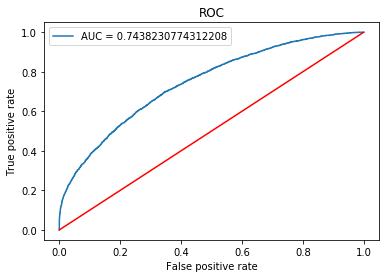

Test:
The model accuracy is 0.8789768523411902
The model f1 is 0.017167381974248927
The model p is 0.38461538461538464
The model recall is 0.00877963125548727
The model KS is 0.31685543612359346
The confusion matrix is:
 [[8306   16]
 [1129   10]]


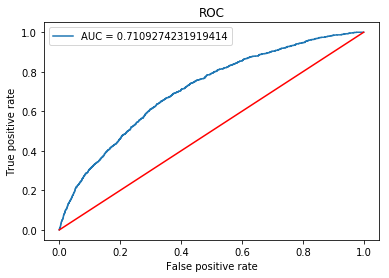

In [37]:
# 训练集
pre_train_cb = model_cb.predict(x_train_cb)
pro_train_cb = model_cb.predict_proba(x_train_cb)[:,1]
# 测试集
pre_test_cb = model_cb.predict(x_test_cb)
pro_test_cb = model_cb.predict_proba(x_test_cb)[:,1]

fpr, tpr, _ = model_performance(y_train_cb, pre_train_cb, pro_train_cb, y_test_cb, pre_test_cb, pro_test_cb)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       620.160380
std         30.807346
min        440.530273
25%        600.405556
50%        620.577269
75%        642.405949
max        694.858773
Name: score, dtype: float64

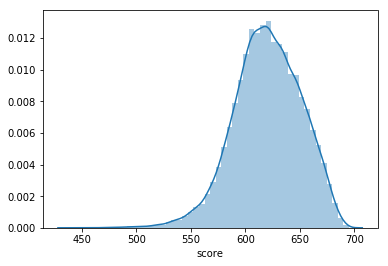

In [38]:
# 模型分数转换
all_pro_cb = pd.concat([pd.Series(pro_train_cb), pd.Series(pro_test_cb)], axis=0)
score_cat = get_model_score(all_pro_cb)
print(score_cat.shape)
save_file(score_cat, 'score_catboost.csv')
# print('Max Score:%s' % max(score_cat.score))
# print('Min Score:%s' % min(score_cat.score))
# 分数整体分布图
sn.distplot(score_cat['score'])
score_cat['score'].describe()

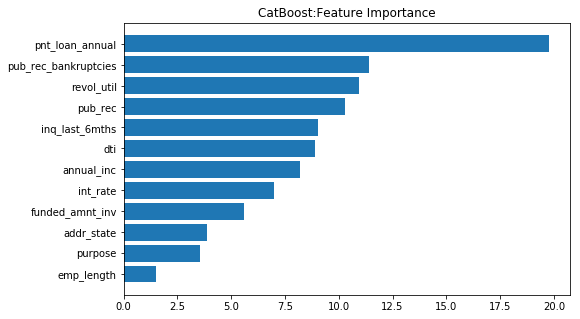

In [39]:
# 特征重要性
fimp_v = model_cb.get_feature_importance()
fimp_n = model_cb.feature_names_
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('CatBoost:Feature Importance')
plt.show()

In [40]:
# ======== 4.2 lightGBM模型 ======== 

In [41]:
# 编码方式可自由选择，也可以使用内置的categorical_feature
# 训练集和测试集划分：7：3
df_model_code = df_model.copy()
for item in sub_char_feature:
    df_model_code[item] = df_model_code[item].astype("category").cat.codes +1
print(df_model_code.shape)

x_train_lgb, x_test_lgb, y_train_lgb, y_test_lgb = train_test_split(df_model_code, df_s['y'], test_size=0.3, random_state=10)
print(x_train_lgb.shape)
print(x_test_lgb.shape)
print(y_train_lgb.shape)
print(y_test_lgb.shape)

(31534, 12)
(22073, 12)
(9461, 12)
(22073,)
(9461,)


In [42]:
# ?lgb.LGBMClassifier()

In [44]:
# 模型训练与结果
model_lgb = lgb_model_run(x_train_lgb, y_train_lgb)
print(model_lgb.get_params())
model_lgb.fit(x_train_lgb, y_train_lgb)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0}


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'max_depth': 8, 'n_estimators': 200} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'subsample': 0.5} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'learning_rate': 0.01} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'reg_alpha': 1, 'reg_lambda': 1} 0.8761835809433425
the other params!
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 1, 'reg_lambda': 1, 'silent': True, 'subsample': 0.5, 'subsample_for_bin': 200000, 'subsample_freq': 0}


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=8,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=1, reg_lambda=1, silent=True,
        subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train:
The model accuracy is 0.8762741811262629
The model f1 is 0.004374772147283996
The model p is 1.0
The model recall is 0.0021921812203142127
The confusion matrix is:
 [[19336     0]
 [ 2731     6]]


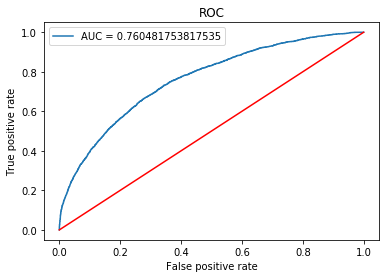

Test:
The model accuracy is 0.8797167318465279
The model f1 is 0.0017543859649122807
The model p is 1.0
The model recall is 0.000877963125548727
The model KS is 0.30445950830267005
The confusion matrix is:
 [[8322    0]
 [1138    1]]


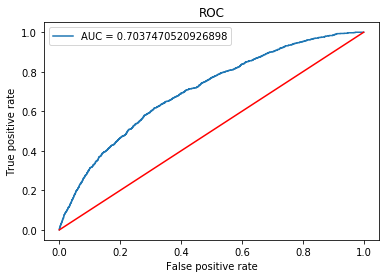

In [45]:
# 训练集
pre_train_lgb = model_lgb.predict(x_train_lgb)
pro_train_lgb = model_lgb.predict_proba(x_train_lgb)[:,1]
# 测试集
pre_test_lgb = model_lgb.predict(x_test_lgb)
pro_test_lgb = model_lgb.predict_proba(x_test_lgb)[:,1]

fpr, tpr, _ = model_performance(y_train_lgb, pre_train_lgb, pro_train_lgb, y_test_lgb, pre_test_lgb, pro_test_lgb)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       620.354015
std         28.565291
min        503.161308
25%        601.617392
50%        620.542023
75%        640.661540
max        675.494371
Name: score, dtype: float64

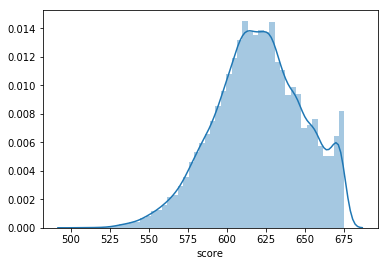

In [46]:
# 模型分数转换
all_pro_lgb = pd.concat([pd.Series(pro_train_lgb), pd.Series(pro_test_lgb)], axis=0)
score_lgb = get_model_score(all_pro_lgb)
print(score_lgb.shape)
save_file(score_lgb, 'score_lightgbm.csv')
# 分数整体分布图
sn.distplot(score_lgb['score'])
score_lgb['score'].describe()

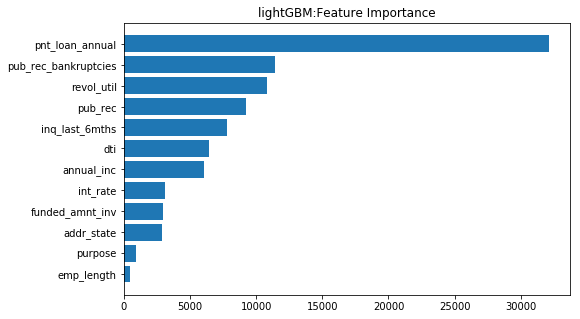

In [47]:
# 特征重要性
fimp_v = model_lgb.booster_.feature_importance(importance_type='gain')
fimp_n = model_lgb.booster_.feature_name()
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('lightGBM:Feature Importance')
plt.show()

In [48]:
# ======== 4.3 XGBoost模型 ======== 

In [49]:
# OneHot Encoder方式
df_model_onehot = df_model.copy()
df_model_onehot = pd.get_dummies(df_model_onehot, columns=['emp_length', 'purpose', 'addr_state'])
print(df_model_onehot.shape)

x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df_model_onehot, df_s['y'], test_size=0.3, random_state=10)
print(x_train_xgb.shape)
print(x_test_xgb.shape)
print(y_train_xgb.shape)
print(y_test_xgb.shape)

(31534, 87)
(22073, 87)
(9461, 87)
(22073,)
(9461,)


In [51]:
# 模型训练与结果
model_xgb = xgb_model_run(x_train_xgb, y_train_xgb)
print(model_xgb.get_params())
model_xgb.fit(x_train_xgb, y_train_xgb)

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': 0, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'n_estimators': 10} 0.8758663980433358
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'subsample': 0.7} 0.8758663980433358
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'learning_rate': 0.05} 0.8758664903901762
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000002446011F158> {'gamma': 0.5, 'reg_lambda': 0.5} 0.8760477318944806
the other params!
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.05, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': 0.5, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, subsample=0.7, tree_method=None,
       validate_parameters=False, verbosity=None)

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train:
The model accuracy is 0.8822543378788565
The model f1 is 0.09913344887348352
The model p is 0.9662162162162162
The model recall is 0.05224698575082207
The confusion matrix is:
 [[19331     5]
 [ 2594   143]]


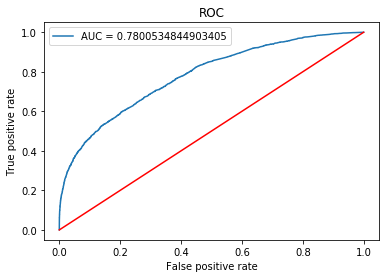

Test:
The model accuracy is 0.878765458196808
The model f1 is 0.02714164546225615
The model p is 0.4
The model recall is 0.014047410008779631
The model KS is 0.28519021162899194
The confusion matrix is:
 [[8298   24]
 [1123   16]]


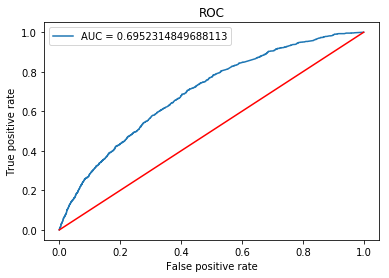

In [52]:
# 训练集
pre_train_xgb = model_xgb.predict(x_train_xgb)
pro_train_xgb = model_xgb.predict_proba(x_train_xgb)[:,1]
# # 测试集
pre_test_xgb = model_xgb.predict(x_test_xgb)
pro_test_xgb = model_xgb.predict_proba(x_test_xgb)[:,1]

fpr, tpr, _ = model_performance(y_train_xgb, pre_train_xgb, pro_train_xgb, y_test_xgb, pre_test_xgb, pro_test_xgb)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       549.869019
std          7.139110
min        488.194519
25%        547.152451
50%        551.329041
75%        555.020081
max        558.257202
Name: score, dtype: float64

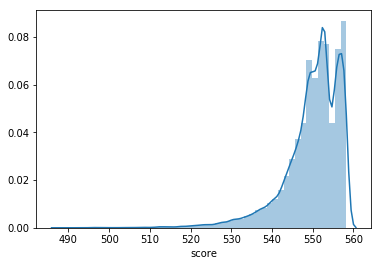

In [53]:
# 模型分数转换
all_pro_xgb = pd.concat([pd.Series(pro_train_xgb), pd.Series(pro_test_xgb)], axis=0)
score_xgb = get_model_score(all_pro_xgb)
print(score_xgb.shape)
save_file(score_xgb, 'score_xgboost.csv')
# 分数整体分布图
sn.distplot(score_xgb['score'])
score_xgb['score'].describe()

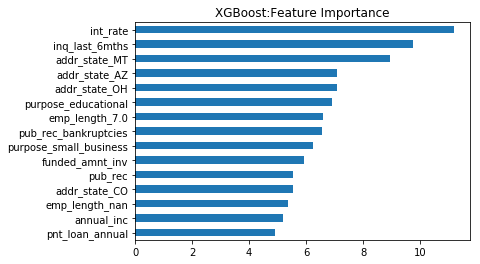

In [54]:
# 特征重要性
score_f = pd.Series(model_xgb.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
# score_f.plot(kind='barh', title='XGBoost:Feature Importance')
score_f12 = score_f[0:15].sort_values()
score_f12.plot(kind='barh', title='XGBoost:Feature Importance')